In [50]:
library(data.table)
library(mixOmics)
library(raster)
library(pracma)
library(ggpubr)
library(gplots)
library(RColorBrewer)
library(mediation)
library(cowplot)
library(caret)
require(randomForest)
library(ROCR)
require(caTools)
source("./R/functions.R")
options(repr.plot.width=10, repr.plot.height=10)
#Schizophrenia EWAS results for sites previously identified as associated with tobacco smoking
tobacco_schizo <- c("cg05575921",
                    "cg01940273",
                    "cg26703534",
                    "cg03636183",
                    "cg05951221",
                    "cg25952192",
                    "cg03274391",
                    "cg01772743",
                    "cg13862853",
                    "cg20566897")
blood_brain_pearson <- read.table("./Blood_Brain_Pearson_CoRR.txt",header = T)

In [2]:
sample_id_phase1 <- read.csv("./GEO/E-GEOD-80417.sdrf.txt",sep = "\t")
sample_id_phase2 <- read.csv("./GEO/E-GEOD-84727.sdrf.txt",sep = "\t")

In [3]:
phase1 <- fread("./GEO/GSE80417_normalizedBetas.csv", header = T)
phase2 <- fread("./GEO/GSE84727_normalisedBetas.csv", header = T)

common_probes <- intersect(phase1$V1,phase2$V1)
common_probes <- setdiff(common_probes,tobacco_schizo)

phase1 <- subset(phase1, V1 %in% common_probes)
phase2 <- subset(phase2, V1 %in% common_probes)

In [4]:
Aberdeen_covariates <- read.csv("./data_sources/AdditionalCovariatesAberdeen.csv")
UCL_covariates <- read.csv("./data_sources/AdditionalCovariatesUCL.csv")

In [5]:
model1 <-read.csv("./model_variables/model_corsiv.csv")
model2 <-read.csv("./model_variables/model_range.csv")
selected_variables <- rbind(model1,model2)
selected_variables  <- selected_variables[!(duplicated(selected_variables$probe_id)),]

In [6]:
phase1 <- subset(phase1, V1 %in% selected_variables$probe_id)
phase2 <- subset(phase2, V1 %in% selected_variables$probe_id)

In [7]:
colnames_phase1 <- phase1$V1
phase1$V1 <- NULL
phase1_t <- data.frame(t(phase1))
colnames(phase1_t) <- colnames_phase1
phase1_t$sample.id <- rownames(phase1_t)
rownames(phase1_t) <- NULL

In [8]:
colnames_phase2 <- phase2$V1
phase2$V1 <- NULL
phase2_t <- data.frame(t(phase2))
colnames(phase2_t) <- colnames_phase2
phase2_t$sample.id <- rownames(phase2_t)
rownames(phase2_t) <- NULL

In [9]:
#phase 2 data to train and phase 1 data to test
test <- data.frame(merge(sample_id_phase1,phase1_t,by.x = "id",by.y = "sample.id"))
train <- data.frame(merge(sample_id_phase2,phase2_t,by.x = "id",by.y = "sample.id"))

In [10]:
head(Aberdeen_covariates)
head(UCL_covariates)
Aberdeen_covariates$cloz <- NULL
UCL_covariates$cloz <- NULL


Basename          smokingScore PlasmaBlast CD8pCD28nCD45RAn CD8.naive
1 3998567027_R01C01 13.076251    1.748857    12.453208        153.5598 
2 3998567027_R02C01 11.166418    1.802734    13.861751        159.9287 
3 3998567027_R03C01 11.094193    1.628653    12.059060        190.0643 
4 3998567027_R04C01 14.373015    1.922215    16.537051        192.9703 
5 3998567027_R05C01 15.883060    1.893910     6.951288        213.0875 
6 3998567027_R06C01  9.698782    1.752264     9.085465        215.9612 
  CD4.naive CD8T       CD4T       NK         Bcell      Mono       Gran     
1 449.9774  0.08930741 0.12998327 0.02912801 0.02741193 0.08193897 0.6071240
2 427.5157  0.03183639 0.11270767 0.06277872 0.02924390 0.09537986 0.6377389
3 482.3159  0.03133318 0.12593794 0.01476804 0.02936250 0.06535940 0.7088081
4 282.5089  0.04313376 0.07832868 0.04027046 0.04581906 0.06070829 0.7314893
5 413.8030  0.05330391 0.10086438 0.00000000 0.09904410 0.05068844 0.6843186
6 512.3938  0.03009161 0.11830703 0.02959263 0.04685475 0.06949262 0.6931092
  cloz
1 NA  
2 NA  
3  1  
4 NA  
5 NA  
6  1

Basename          PlasmaBlast CD8pCD28nCD45RAn CD8.naive CD4.naive CD8T      
1 9704031032_R02C01 1.503589     7.907739        309.7345  461.7186  0.10736089
2 9704031032_R06C01 1.570982    12.401518        145.5583  307.5373  0.04403277
3 9721367113_R04C02 1.591187    15.322913        163.8781  320.1196  0.07460840
4 9721367113_R05C01 1.586029     9.040199        225.5692  427.6956  0.05031361
5 9721367113_R06C01 1.705579    10.270772        165.6787  190.5521  0.04027610
6 9721367113_R06C02 1.636100     7.633269        276.2883  498.3339  0.06473530
  CD4T       NK          Bcell      Mono       Gran      smokingScore cloz
1 0.15189216 0.000000000 0.03897269 0.06405199 0.5749416 -3.656180    NA  
2 0.14440800 0.038900309 0.04714918 0.08341840 0.6166383 -2.177073    NA  
3 0.08165123 0.008136236 0.05599000 0.10984418 0.6012898  9.033510    NA  
4 0.06641923 0.059124241 0.02720509 0.11597642 0.6128118  5.673556     0  
5 0.11180634 0.042163734 0.03843766 0.07071841 0.6267167 -3.063196    NA  
6 0.14295427 0.000000000 0.04120657 0.07732079 0.5964837 -2.282893    NA

In [11]:
train <- merge(train,Aberdeen_covariates,by.x = "id",by.y="Basename")
test <- merge(test,UCL_covariates,by.x = "id",by.y = "Basename")

In [12]:
#build on phase 2
train$CaseControl <- NULL
train$id <- NULL
train$sample_title <- NULL
train$status <- as.factor(ifelse(train$status==1,0,1))

test$CaseControl <- NULL
test$id  <- NULL
test$gender <- NULL
test$age <- NULL
test$status <- as.factor(ifelse(test$status==1,0,1))

In [13]:
dim(train)
head(train)

dim(test)
head(test)

[1] 847 235

status cg00117018 cg00158530 cg00159523 cg00175403 cg00326788 cg00923880
1 0      0.5021726  0.4240359  0.2764018  0.4526078  0.8553140  0.2820742 
2 1      0.3731366  0.4466228  0.3145658  0.5042548  0.8849143  0.4715864 
3 1      0.4682677  0.4213204  0.2921170  0.4458140  0.8477416  0.2916336 
4 1      0.4953445  0.5698118  0.3783251  0.4415782  0.8964611  0.2951902 
5 0      0.5064712  0.4731871  0.3419775  0.4555819  0.8783873  0.3118205 
6 1      0.4747608  0.5979082  0.4369480  0.4346929  0.8739837  0.4724115 
  cg00982641 cg01074767 cg01238044 ⋯ PlasmaBlast CD8pCD28nCD45RAn CD8.naive
1 0.9428834  0.6532536  0.1405311  ⋯ 1.495034     5.010544        264.6102 
2 0.9375498  0.5415517  0.6728921  ⋯ 1.685901     8.207607        339.5059 
3 0.9567469  0.6305955  0.1488553  ⋯ 1.733543     6.828892        314.9606 
4 0.9416441  0.3625547  0.1596042  ⋯ 1.709298    10.761549        181.2007 
5 0.9383263  0.3798386  0.1544214  ⋯ 1.532281    12.364301        254.0565 
6 0.9050412  0.2018080  0.1883682  ⋯ 1.592663     6.205416        241.7965 
  CD4.naive CD8T       CD4T       NK         Bcell      Mono       Gran     
1 618.5194  0.02941703 0.22219876 0.00929855 0.04103739 0.07793779 0.5966523
2 627.3506  0.03422605 0.18529370 0.00000000 0.10295019 0.05221976 0.5981941
3 453.3910  0.08313464 0.09884639 0.02021404 0.06240291 0.13760769 0.5706918
4 441.4300  0.07552475 0.17401723 0.00000000 0.05644695 0.05296620 0.6146513
5 526.9594  0.14414085 0.14015960 0.02839097 0.04805359 0.06756914 0.5572256
6 427.9712  0.03076730 0.15851233 0.07113915 0.07354820 0.06736145 0.6001263

[1] 675 235

status cg00117018 cg00158530 cg00159523 cg00175403 cg00326788 cg00923880
1 0      0.5043788  0.5365192  0.6013056  0.5429564  0.8440444  0.2943476 
2 0      0.5085758  0.7626089  0.3739209  0.4982667  0.8855240  0.3029317 
3 1      0.5186544  0.4333482  0.5610170  0.5418182  0.9217886  0.2624287 
4 1      0.3481240  0.5932379  0.3606728  0.4979507  0.8782311  0.3063291 
5 0      0.5075716  0.3914078  0.4574615  0.5142674  0.9061912  0.2640076 
6 0      0.5771362  0.4265995  0.2915743  0.5221569  0.8668481  0.3171918 
  cg00982641 cg01074767 cg01238044 ⋯ CD8pCD28nCD45RAn CD8.naive CD4.naive
1 0.9558280  0.6607521  0.1601353  ⋯  7.907739        309.7345  461.7186 
2 0.9728607  0.5885223  0.1986757  ⋯ 12.401518        145.5583  307.5373 
3 0.9615735  0.4121563  0.5079295  ⋯ 15.322913        163.8781  320.1196 
4 0.9669736  0.5948677  0.6428501  ⋯  9.040199        225.5692  427.6956 
5 0.9566282  0.6246243  0.1821363  ⋯ 10.270772        165.6787  190.5521 
6 0.9601847  0.2050806  0.8639375  ⋯  7.633269        276.2883  498.3339 
  CD8T       CD4T       NK          Bcell      Mono       Gran     
1 0.10736089 0.15189216 0.000000000 0.03897269 0.06405199 0.5749416
2 0.04403277 0.14440800 0.038900309 0.04714918 0.08341840 0.6166383
3 0.07460840 0.08165123 0.008136236 0.05599000 0.10984418 0.6012898
4 0.05031361 0.06641923 0.059124241 0.02720509 0.11597642 0.6128118
5 0.04027610 0.11180634 0.042163734 0.03843766 0.07071841 0.6267167
6 0.06473530 0.14295427 0.000000000 0.04120657 0.07732079 0.5964837
  smokingScore
1 -3.656180   
2 -2.177073   
3  9.033510   
4  5.673556   
5 -3.063196   
6 -2.282893

In [14]:
X <- train[,2:235]
Y <- train$status

In [15]:
list.keepX <- seq(1,230,10)
tune.splsda.final <- tune.splsda(X, Y, ncomp =6 , validation = 'Mfold', folds = 5, 
                           progressBar = TRUE, dist = 'max.dist', measure = "AUC",
                          test.keepX = list.keepX, nrepeat = 10, cpus = 6)
error <- tune.splsda.final$error.rate  # error rate per component for the keepX grid
ncomp <- tune.splsda.final$choice.ncomp$ncomp # optimal number of components based on t-tests
ncomp


comp 1 
  |======================================================================| 100%
comp 2 
  |======================================================================| 100%
comp 3 
  |======================================================================| 100%
comp 4 
  |======================================================================| 100%
comp 5 
  |======================================================================| 100%
comp 6 
  |======================================================================| 100%


[1] 3

comp1 comp2 comp3 
  221   221   221

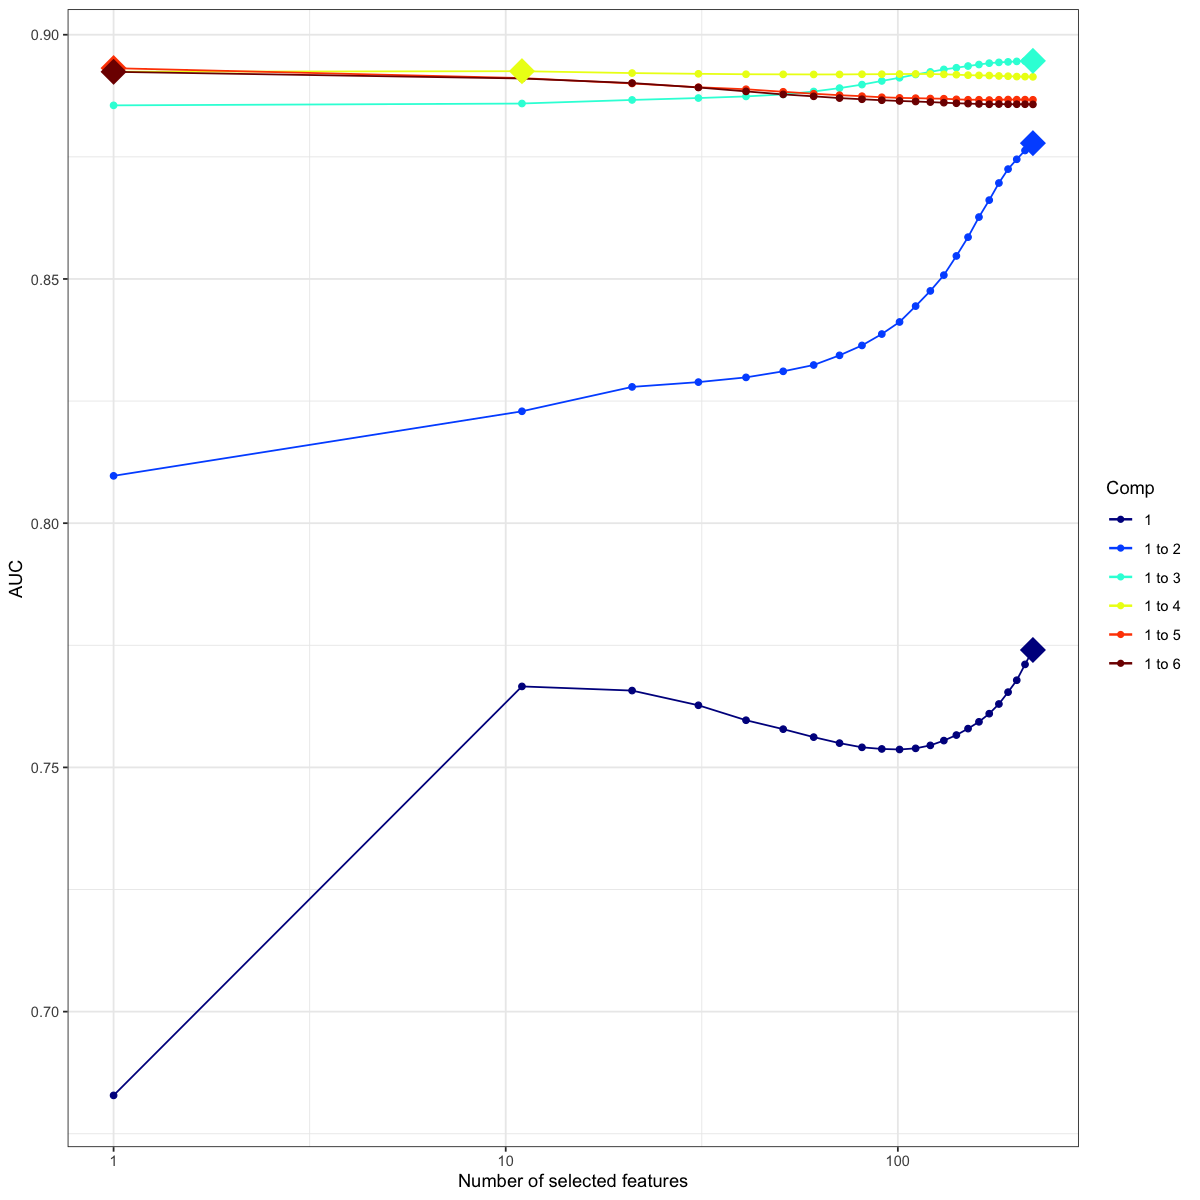

In [16]:
select.keepX <- tune.splsda.final$choice.keepX[1:ncomp]  # optimal number of variables to select
select.keepX
plot(tune.splsda.final, col = color.jet(6))

In [17]:
splsda_output_beta <- mixOmics::splsda(X = subset(train,select = -c(status)),
                                        Y = train$status,ncomp = 3,keepX=c(50,50,50))

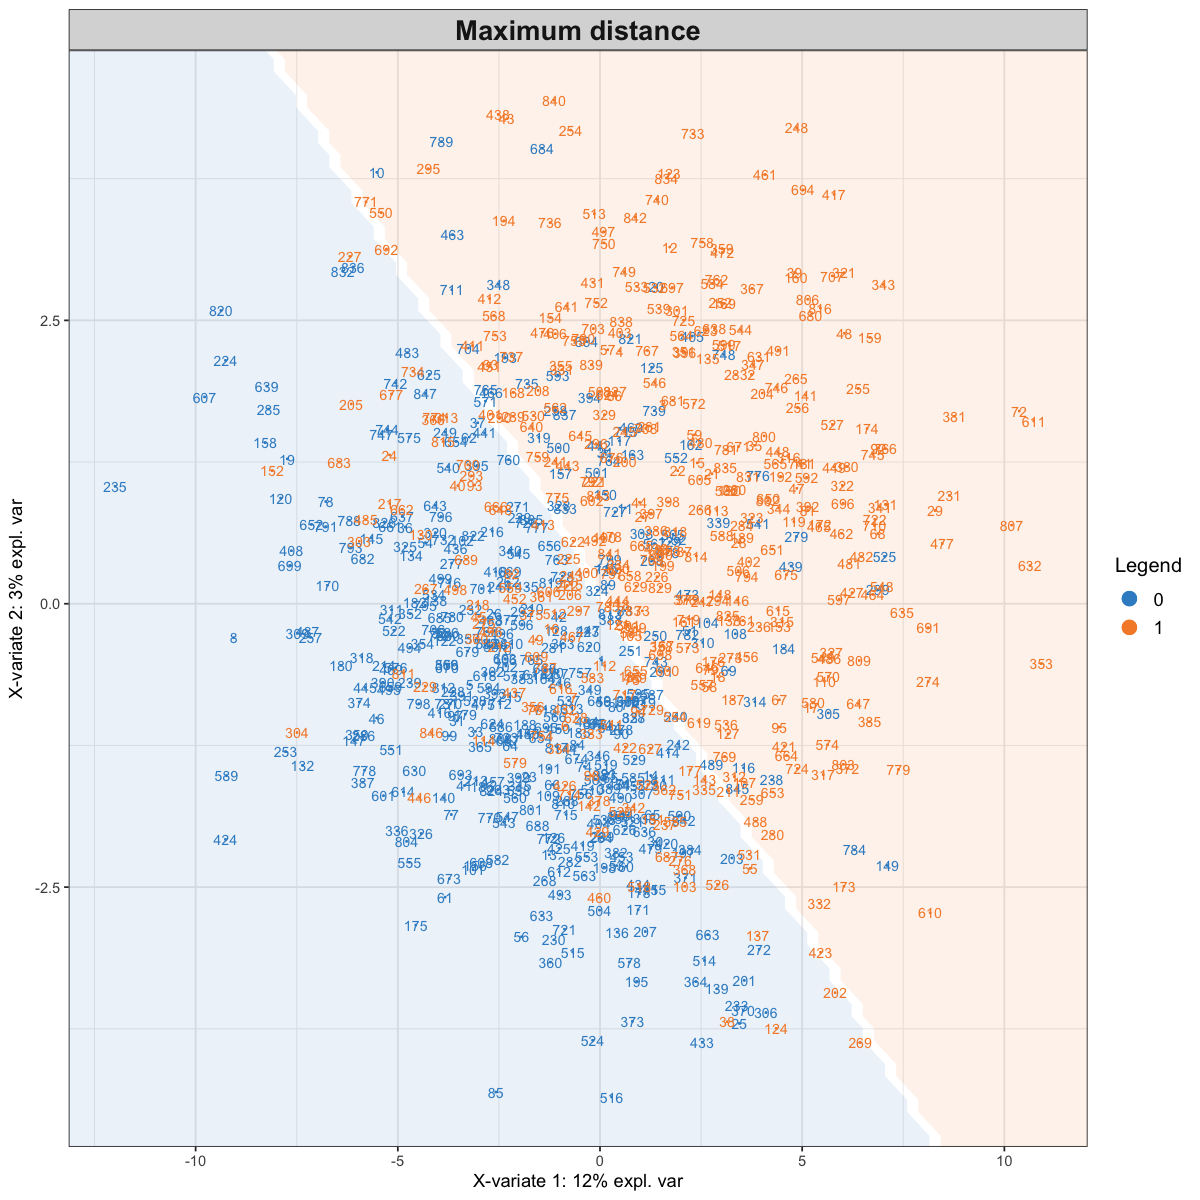

In [18]:
# with background
background = background.predict(splsda_output_beta, comp.predicted=2, dist = "max.dist") 
#optional: xlim = c(-40,40), ylim = c(-30,30))

plotIndiv(splsda_output_beta, comp = 1:2,
          group = as.factor(train$status), title = "Maximum distance",
          legend = TRUE,  background = background)

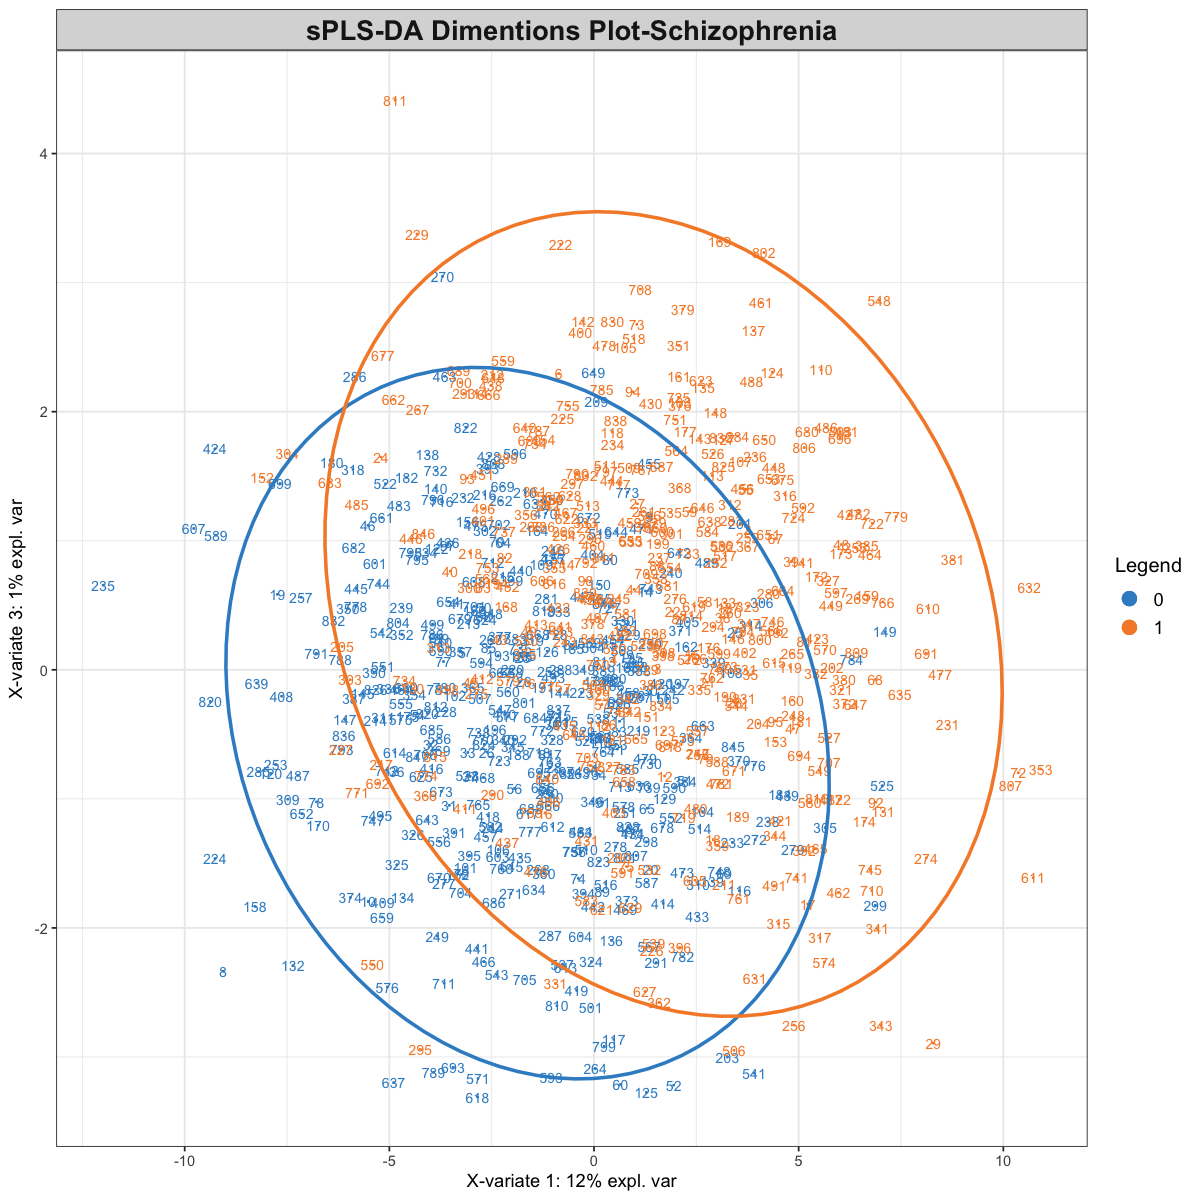

In [19]:
v <- plotIndiv(splsda_output_beta, legend=TRUE,comp = c(1,3),
               ellipse = T, star = FALSE, title = paste0('sPLS-DA Dimentions Plot-',"Schizophrenia"))
#confidence level set to 95%

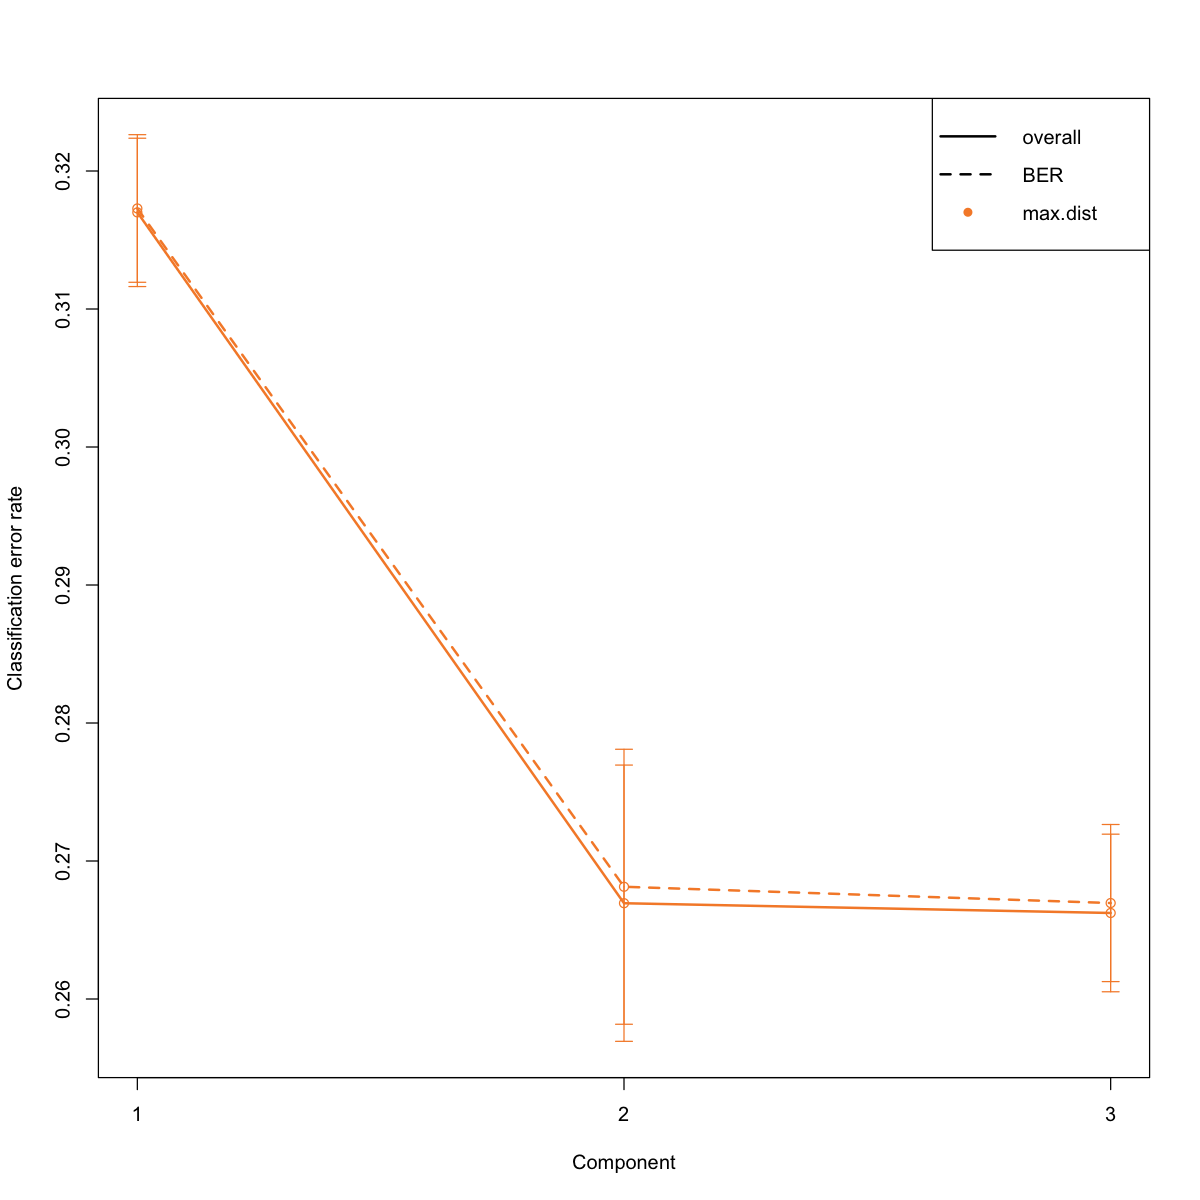

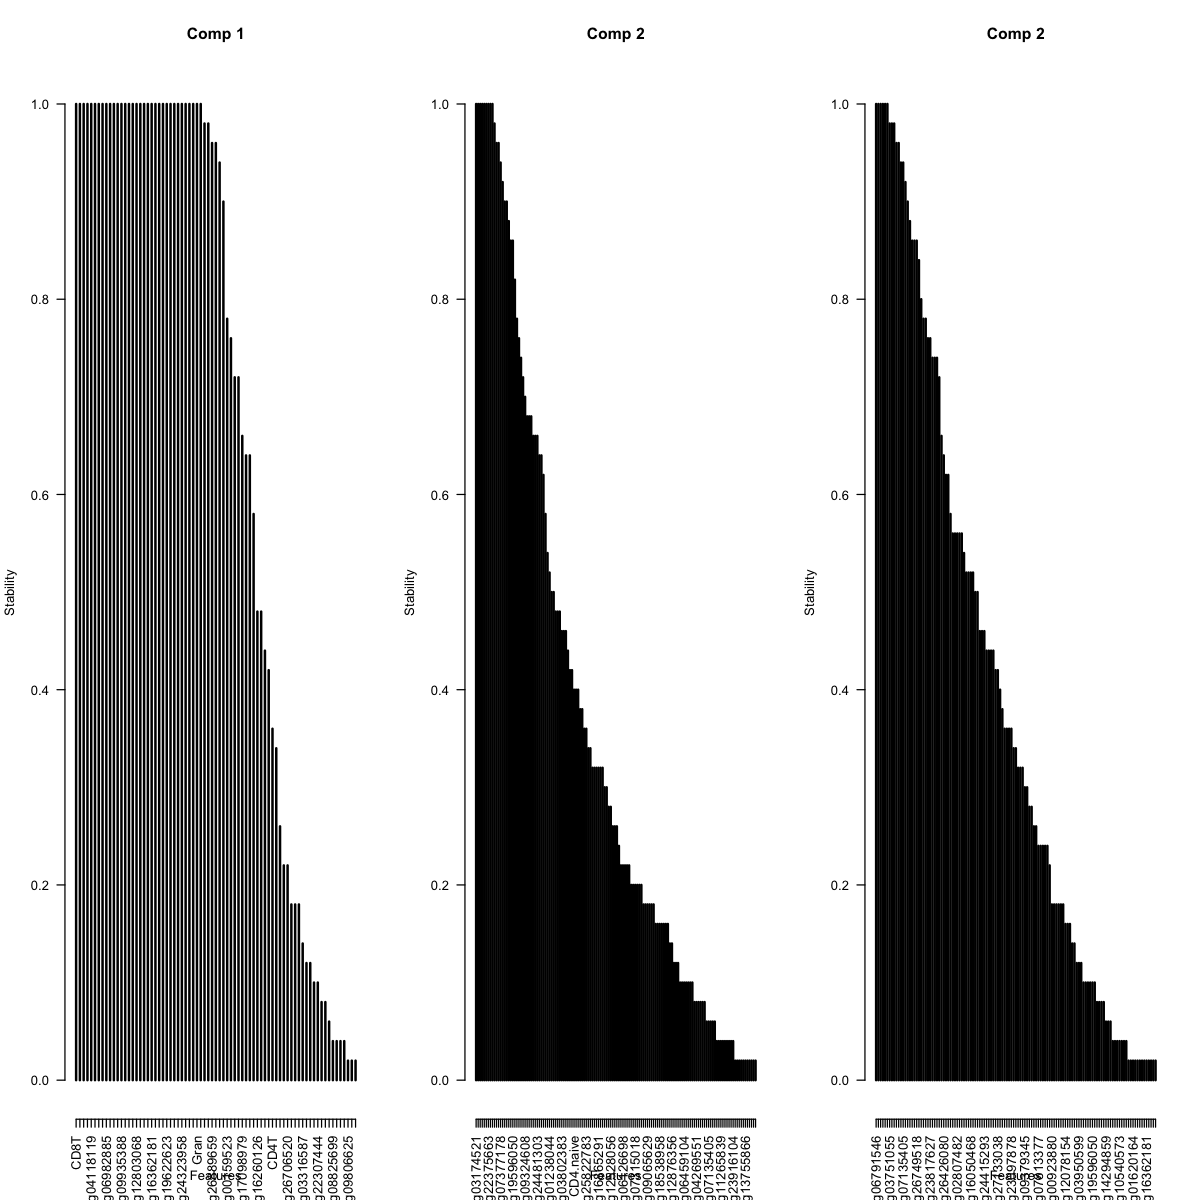

In [20]:
set.seed(40) # for reproducibility, only when the `cpus' argument is not used
# takes about 1 min to run
perf.srbct <- perf(splsda_output_beta, validation = "Mfold", folds = 5,
                   dist = 'max.dist', nrepeat = 10,
                   progressBar = FALSE) 
plot(perf.srbct, col = color.mixo(2))

par(mfrow=c(1,3))
plot(perf.srbct$features$stable[[1]], type = 'h', ylab = 'Stability', 
     xlab = 'Features', main = 'Comp 1', las =2)
plot(perf.srbct$features$stable[[2]], type = 'h', ylab = 'Stability', 
     xlab = 'Features', main = 'Comp 2', las =2)
plot(perf.srbct$features$stable[[3]], type = 'h', ylab = 'Stability', 
     xlab = 'Features', main = 'Comp 2', las =2)

# here we match the selected variables to the stable features
ind.match = match(selectVar(splsda_output_beta, comp = 1)$name, 
                  names(perf.srbct$features$stable[[1]]))
#extract the frequency of selection of those selected variables
Freq = as.numeric(perf.srbct$features$stable[[1]][ind.match])


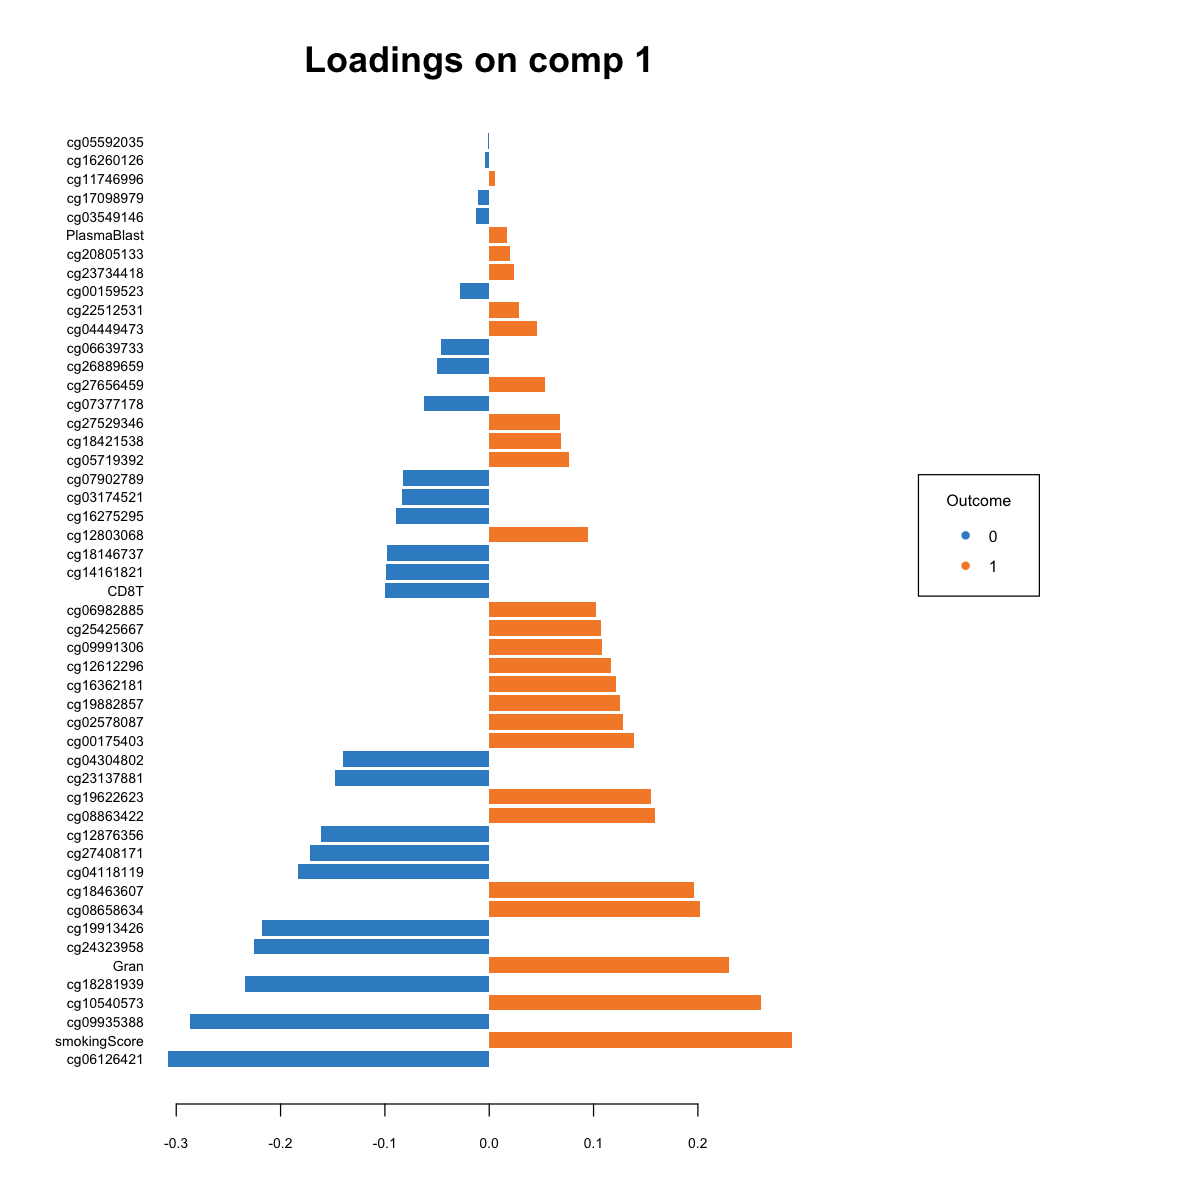

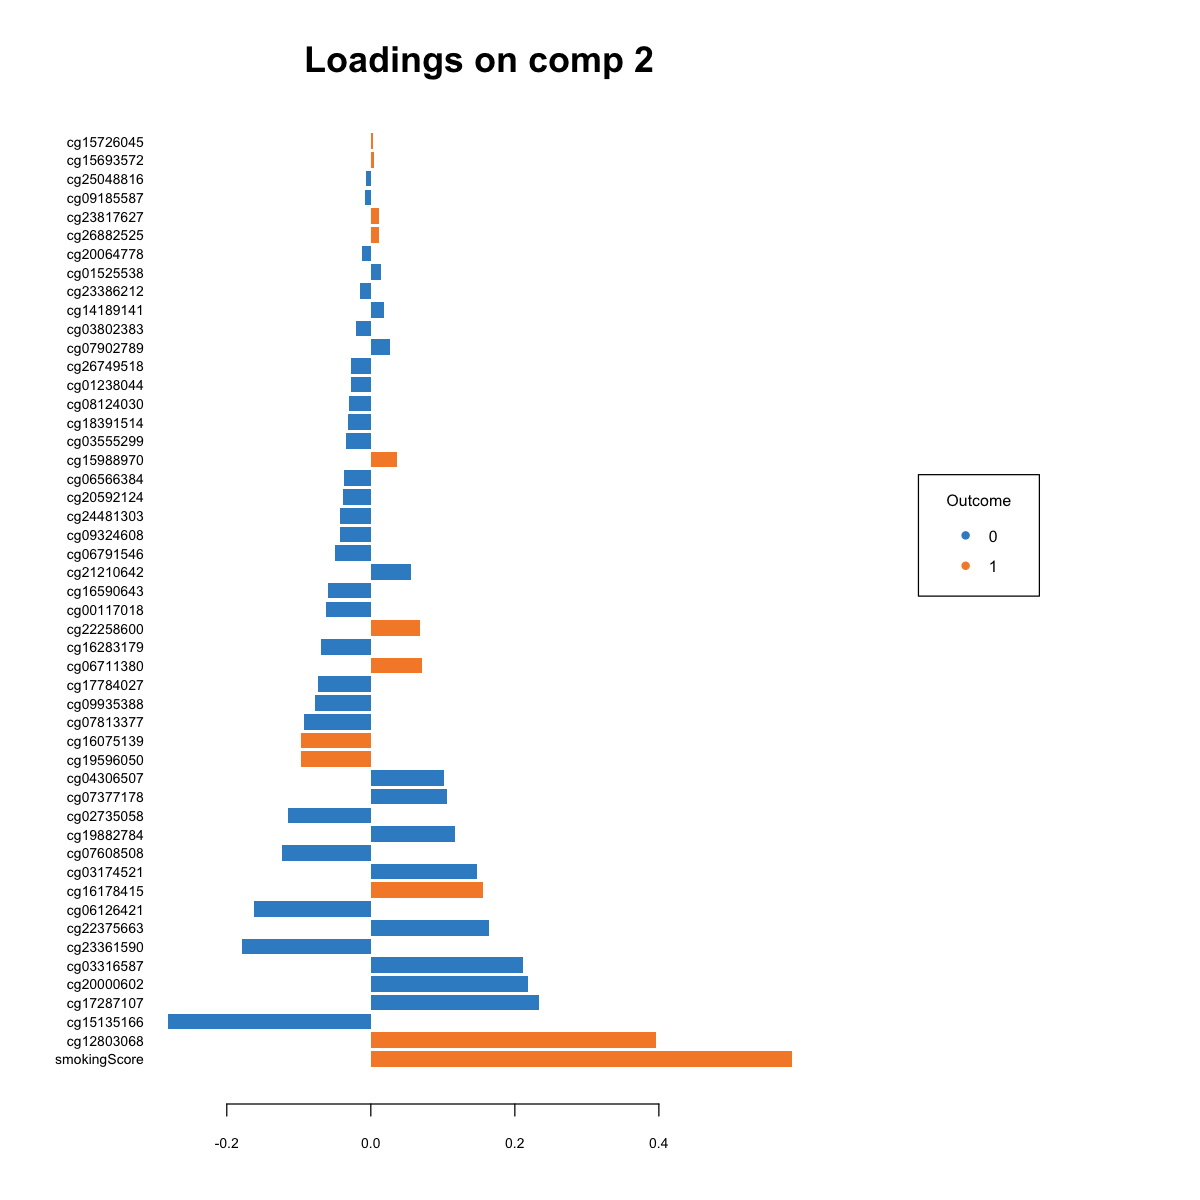

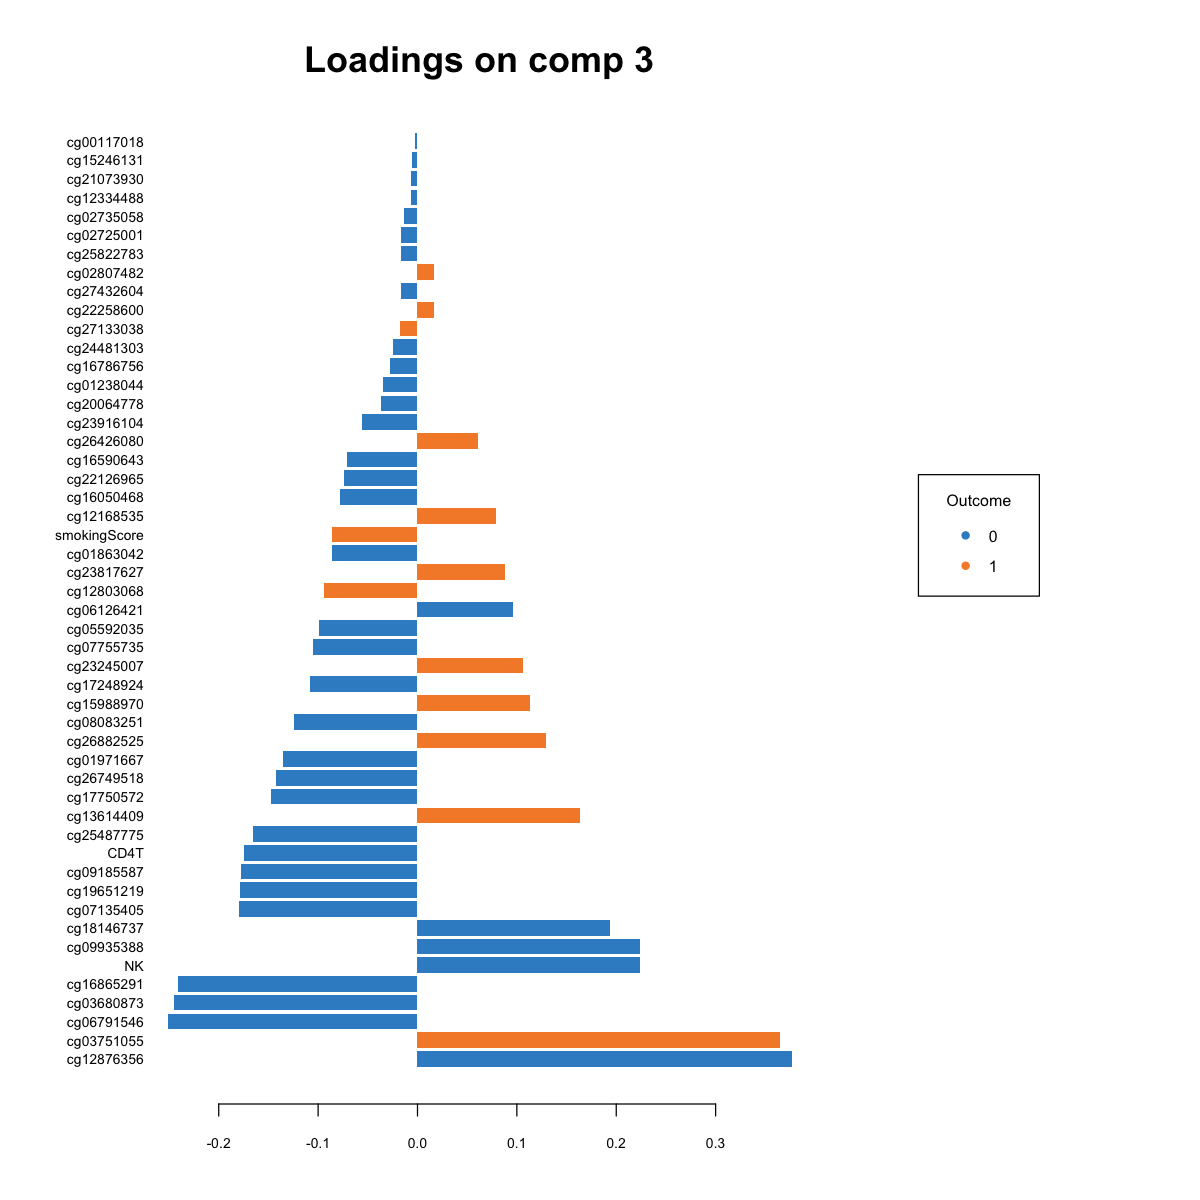

In [21]:
plotLoadings(splsda_output_beta, comp = 1, title = 'Loadings on comp 1', 
             contrib = 'max', method = 'mean')
plotLoadings(splsda_output_beta, comp = 2, title = 'Loadings on comp 2', 
             contrib = 'max', method = 'mean')
plotLoadings(splsda_output_beta, comp = 3, title = 'Loadings on comp 3', 
             contrib = 'max', method = 'mean')

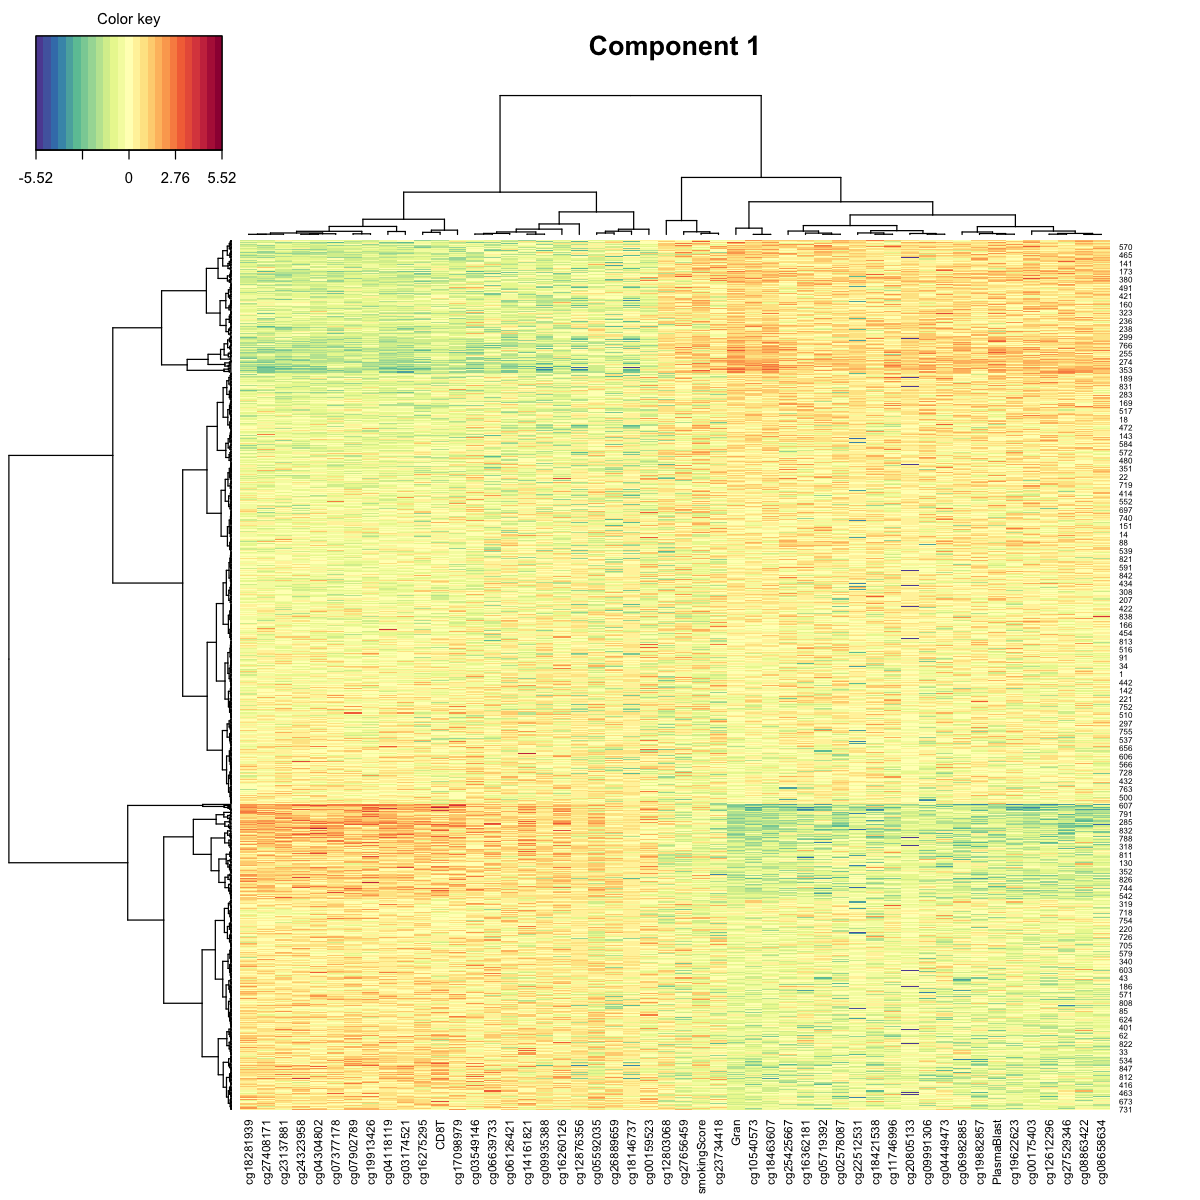

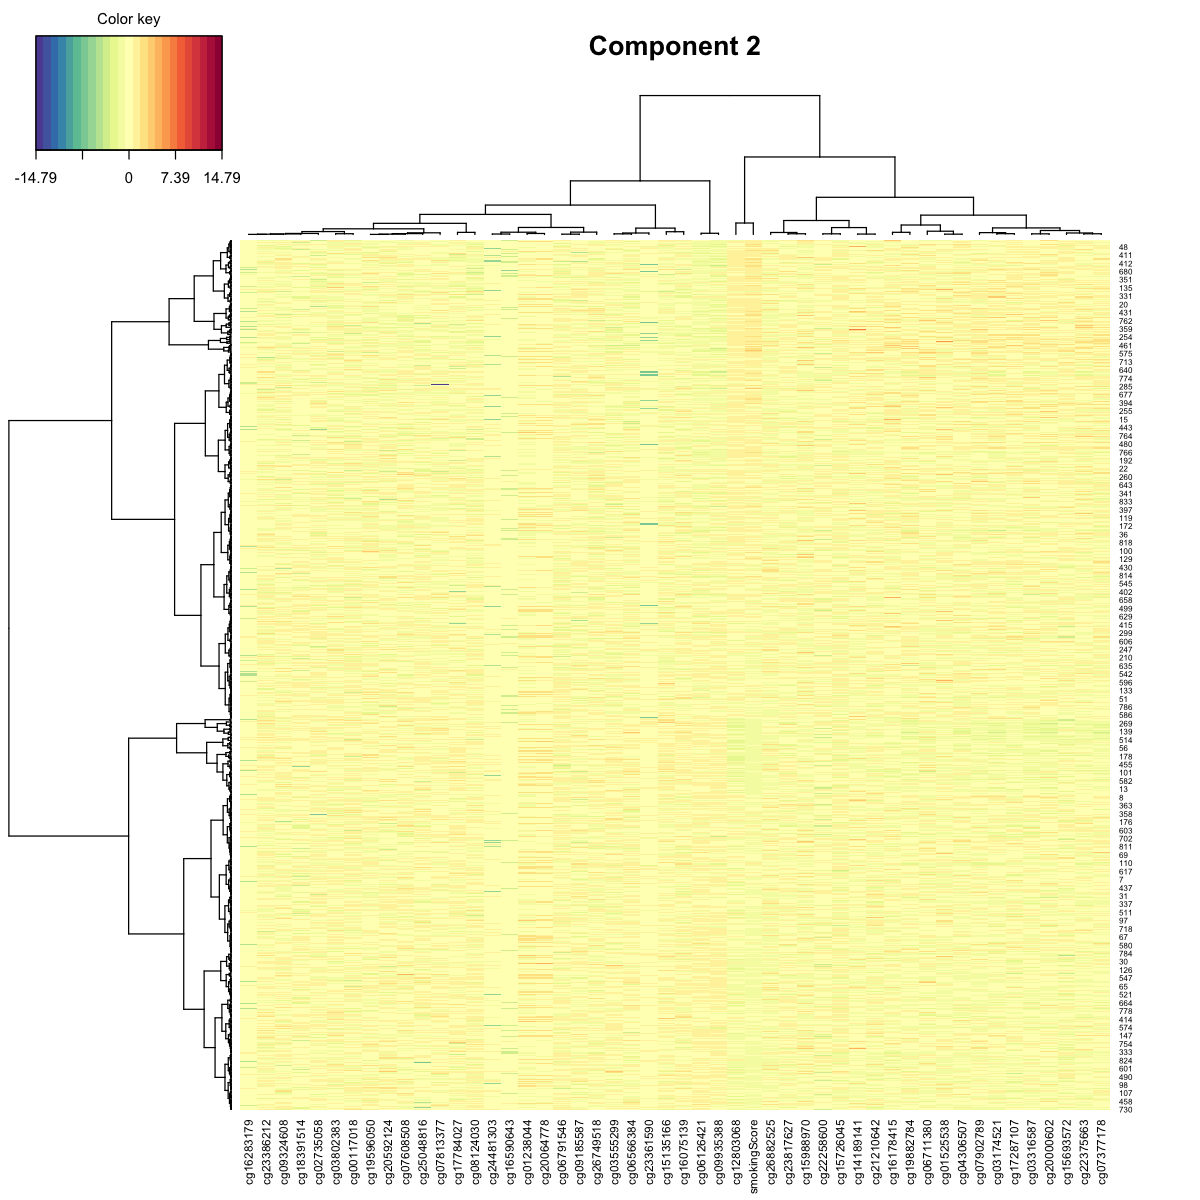

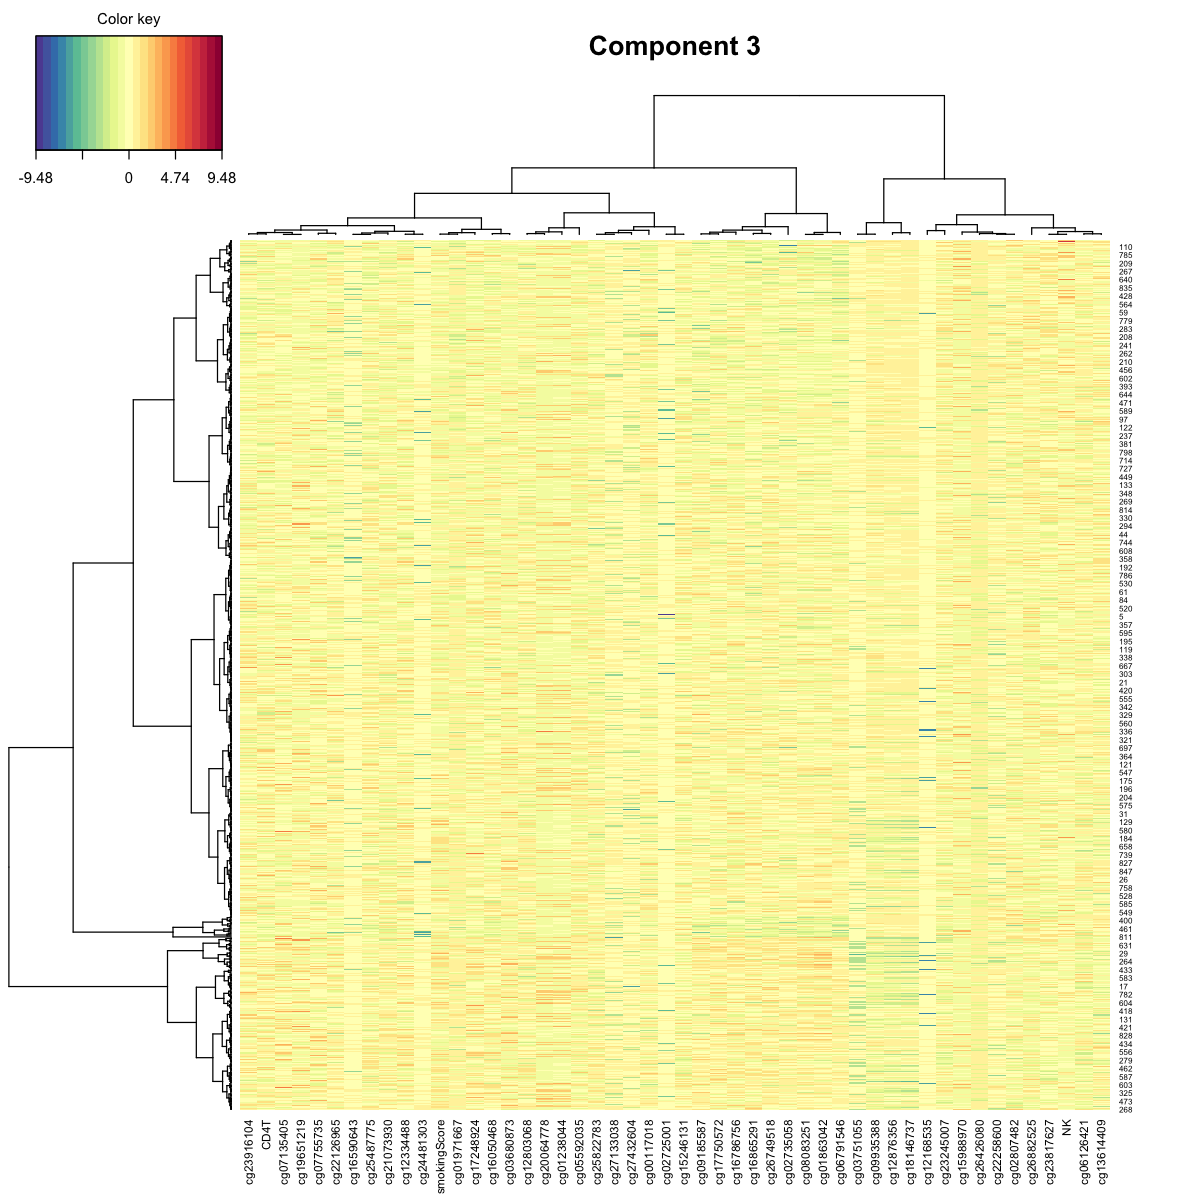

In [22]:
cim(splsda_output_beta,comp=1, title ="Component 1")
cim(splsda_output_beta,comp=2, title ="Component 2")
cim(splsda_output_beta,comp=3, title ="Component 3")

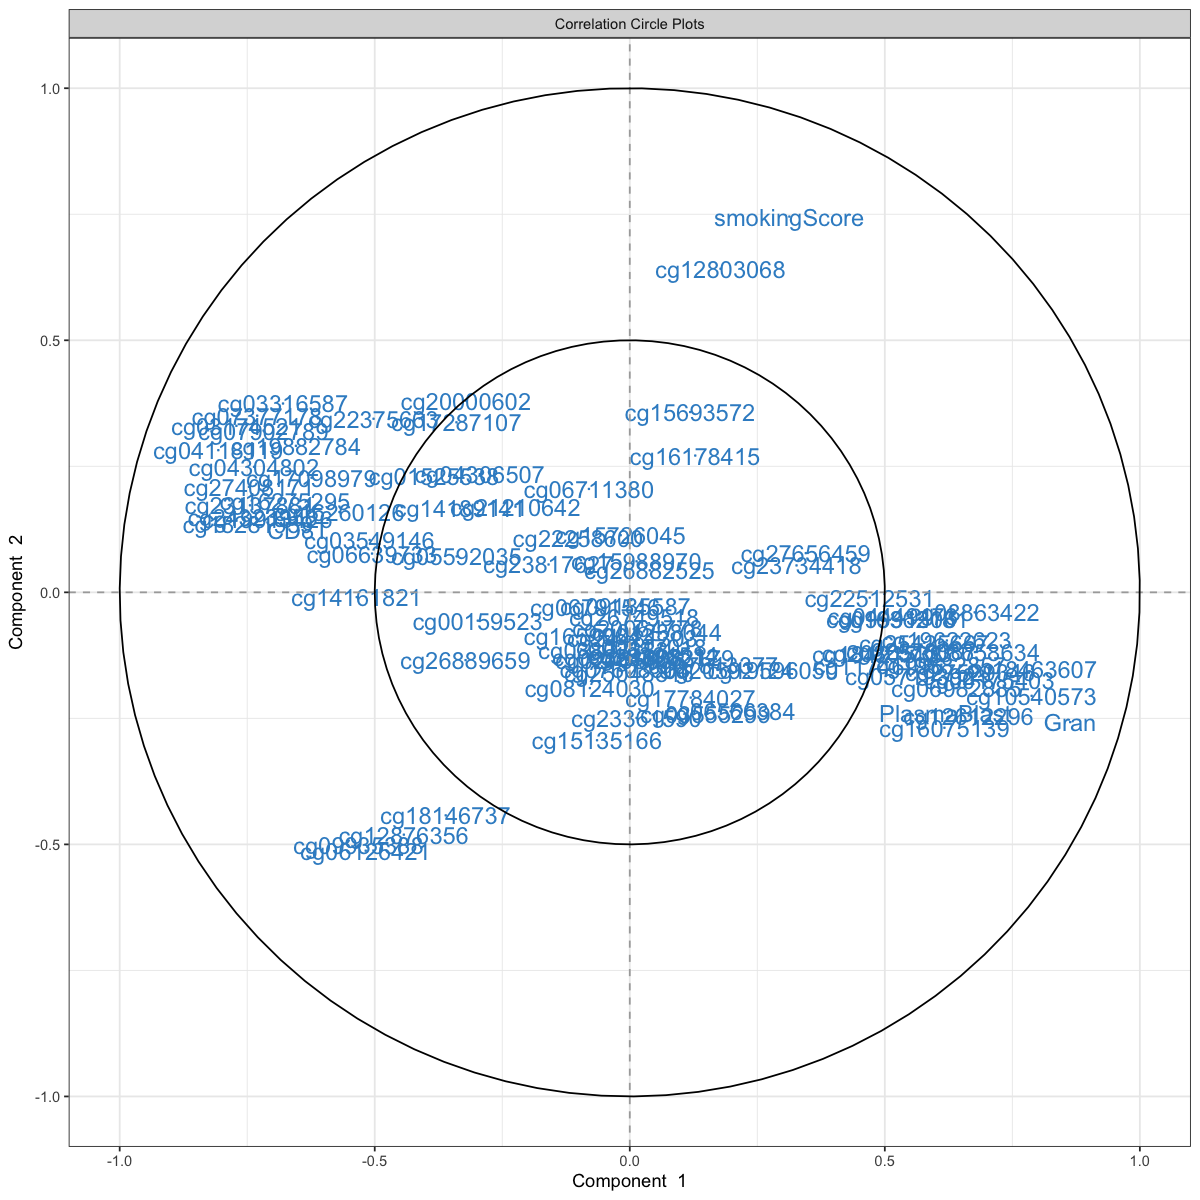

In [23]:
plotVar(splsda_output_beta)

Loading required package: scales



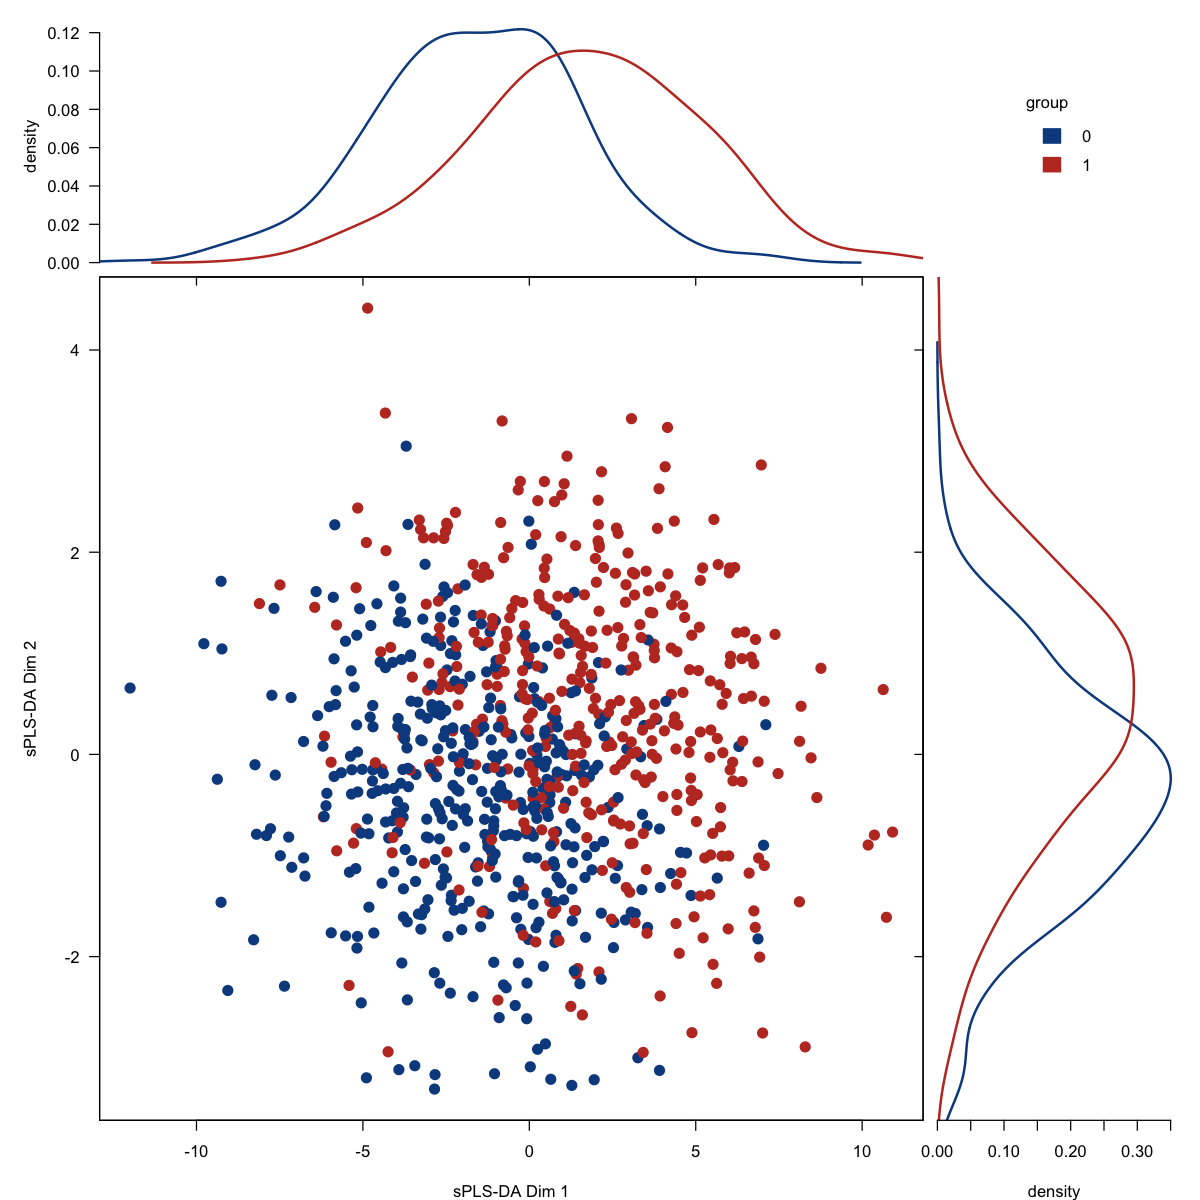

In [24]:
plsdaDF <- as.data.frame(v$df)
highest_x_y <- ceiling(max(max(abs(plsdaDF$x)),max(abs(plsdaDF$y))))
marginal_plot(x = x, y = y, group = group, data = v$df,
              bw = "nrd", lm_formula = NULL, xlab = "sPLS-DA Dim 1", ylab = "sPLS-DA Dim 2", pch = 16, cex =1.5)

In [25]:
var(plsdaDF$x)
var(plsdaDF$y)
rad2deg(atan2(2,1))

[1] 12.96896

[1] 1.618497

[1] 63.43495

[1] 1.303957
[1] -0.905727


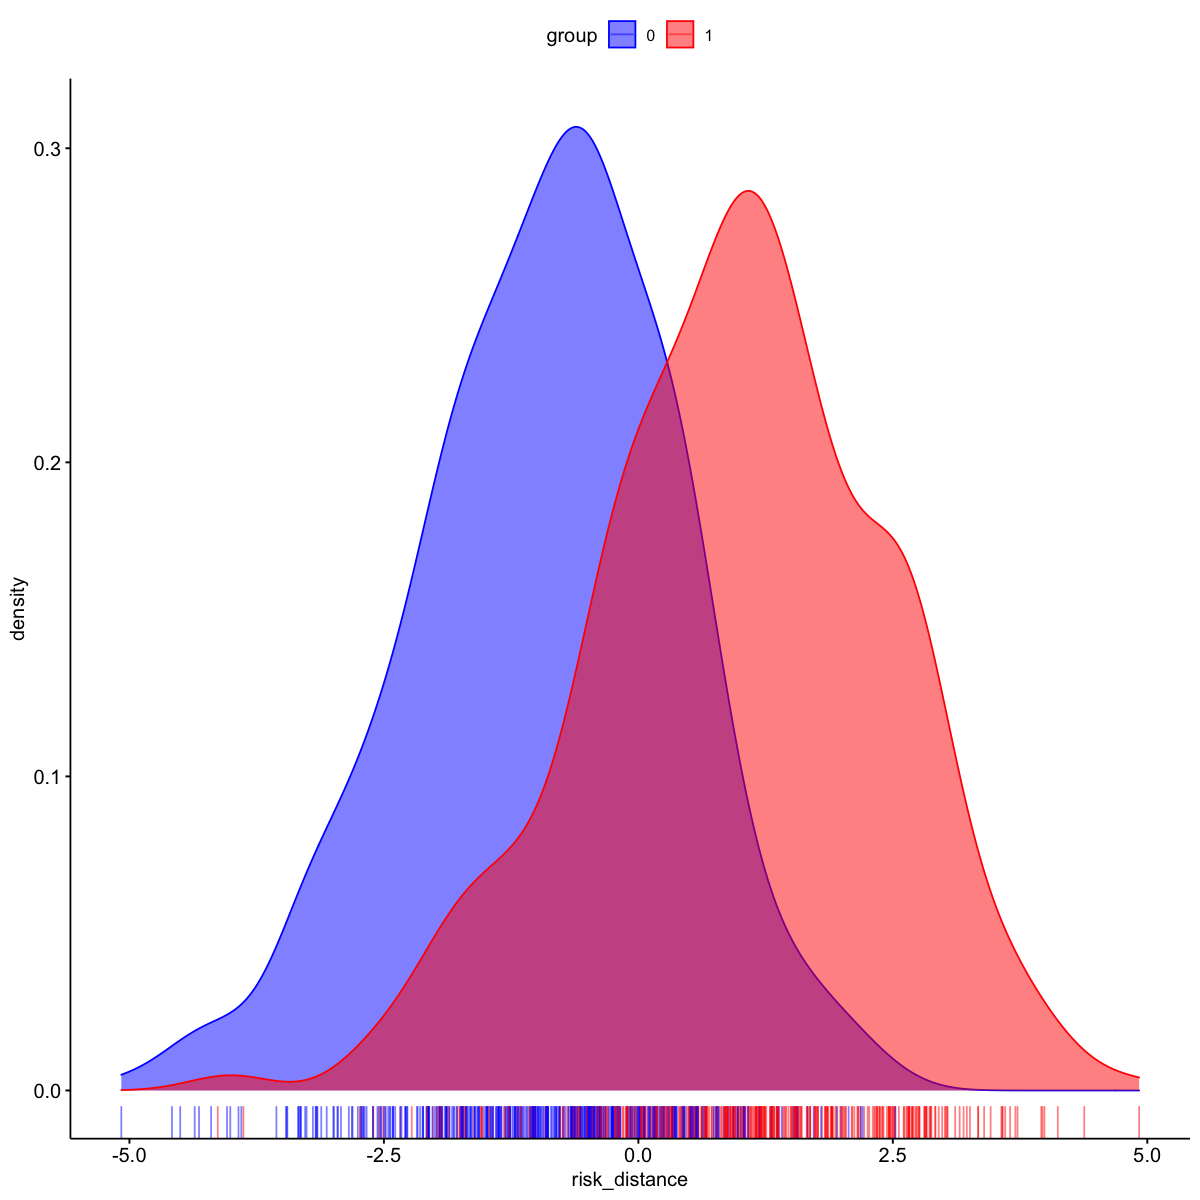

In [26]:
# plsdaDF <- as.data.frame(v$df)
highest_x_y <- ceiling(max(max(abs(plsdaDF$x)),max(abs(plsdaDF$y))))
risk_distance <- function(cancer_sample){
    X <- as.numeric(cancer_sample[1])
    Y <- as.numeric(cancer_sample[2])
    d <- pointDistance(c(0,0),c(X,Y),lonlat = F)
    return(d*cos(atan2(Y,X) + deg2rad(180-rad2deg(atan2(3,1)))))# - for MBCN + for BC
    #return(d*cos(atan2(Y,X) + deg2rad(45)))# - for MBCN + for BC

}
plsdaDF$risk_distance <- -1*apply(plsdaDF, 1, risk_distance)
plot.data <- plsdaDF[c("group","risk_distance")]
cutoff <- 2*sd(plot.data[plot.data$group==0,]$risk_distance)
ggdensity(plot.data, x = "risk_distance",
          rug = TRUE,
          color = "group", fill = "group",
          palette = c("blue", "red"))
stdev_controls <- sd(plot.data[plot.data$group==0,]$risk_distance)#increase n
mean_controls <- mean(plot.data[plot.data$group==0,]$risk_distance)
print(stdev_controls)
print(mean_controls)

In [27]:
Y <- test$status

In [28]:
test <- test[colnames(splsda_output_beta$X)]

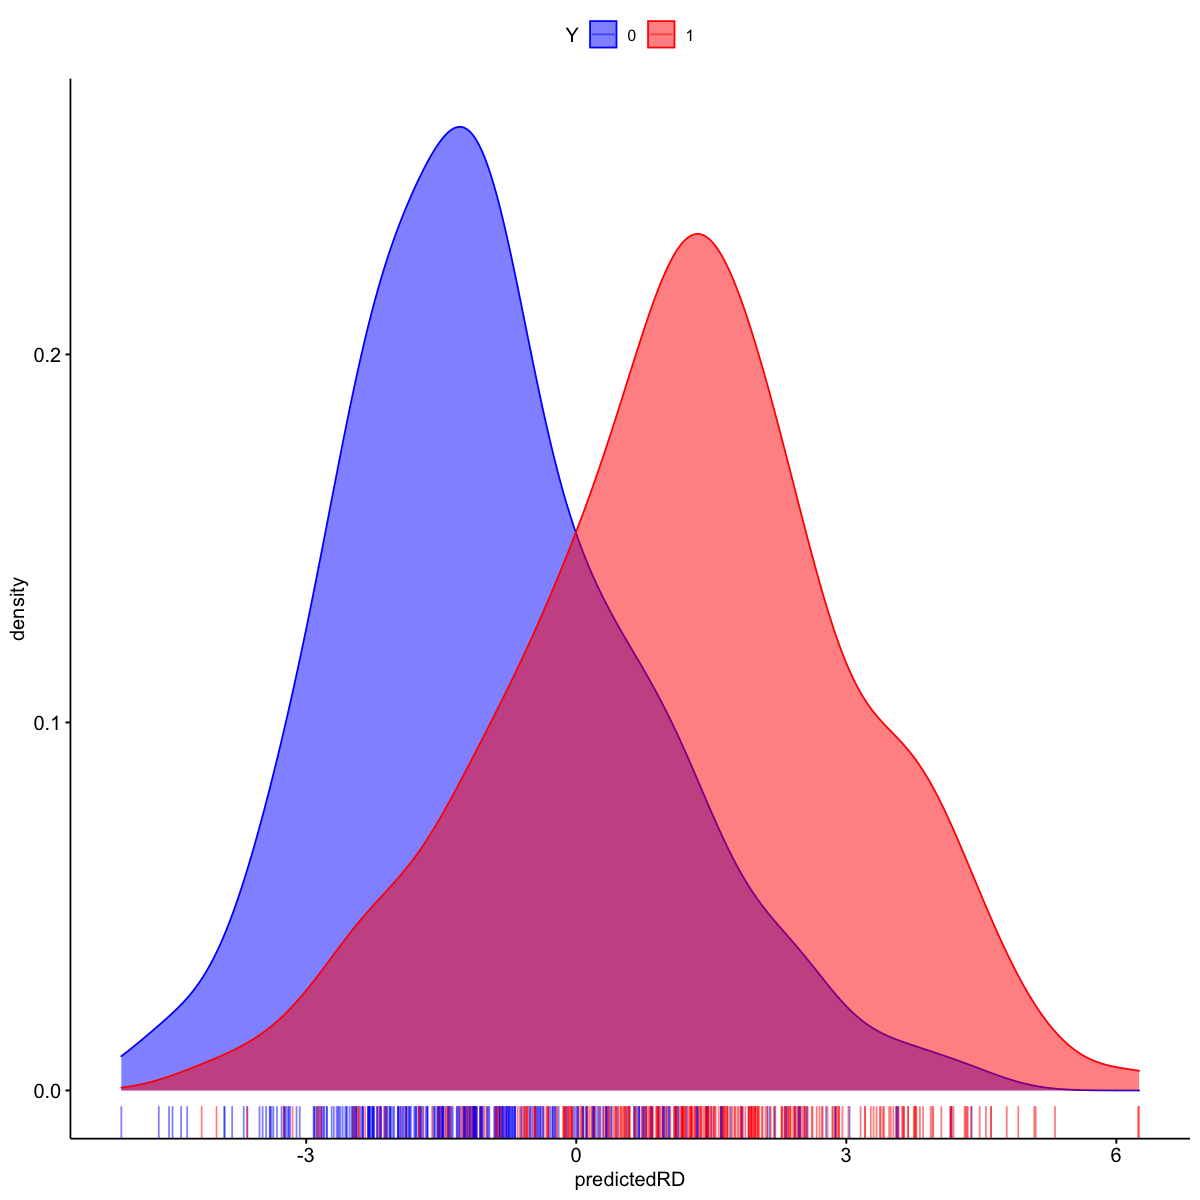

In [29]:
########### PREDICTION ######
##########################################################################

#test$status <- NULL
test.predict <- predict(splsda_output_beta, test)

predicted_RD <- data.frame(-1*apply(test.predict$variates,1,risk_distance))
predicted_RD$Y <- as.numeric(as.character(Y))
colnames(predicted_RD) <- c("predictedRD","Y")

predicted_RD$Y <- as.factor(predicted_RD$Y)
ggdensity(predicted_RD, x = "predictedRD",
          rug = TRUE,
          color = "Y", fill = "Y",
          palette = c("blue", "red"))

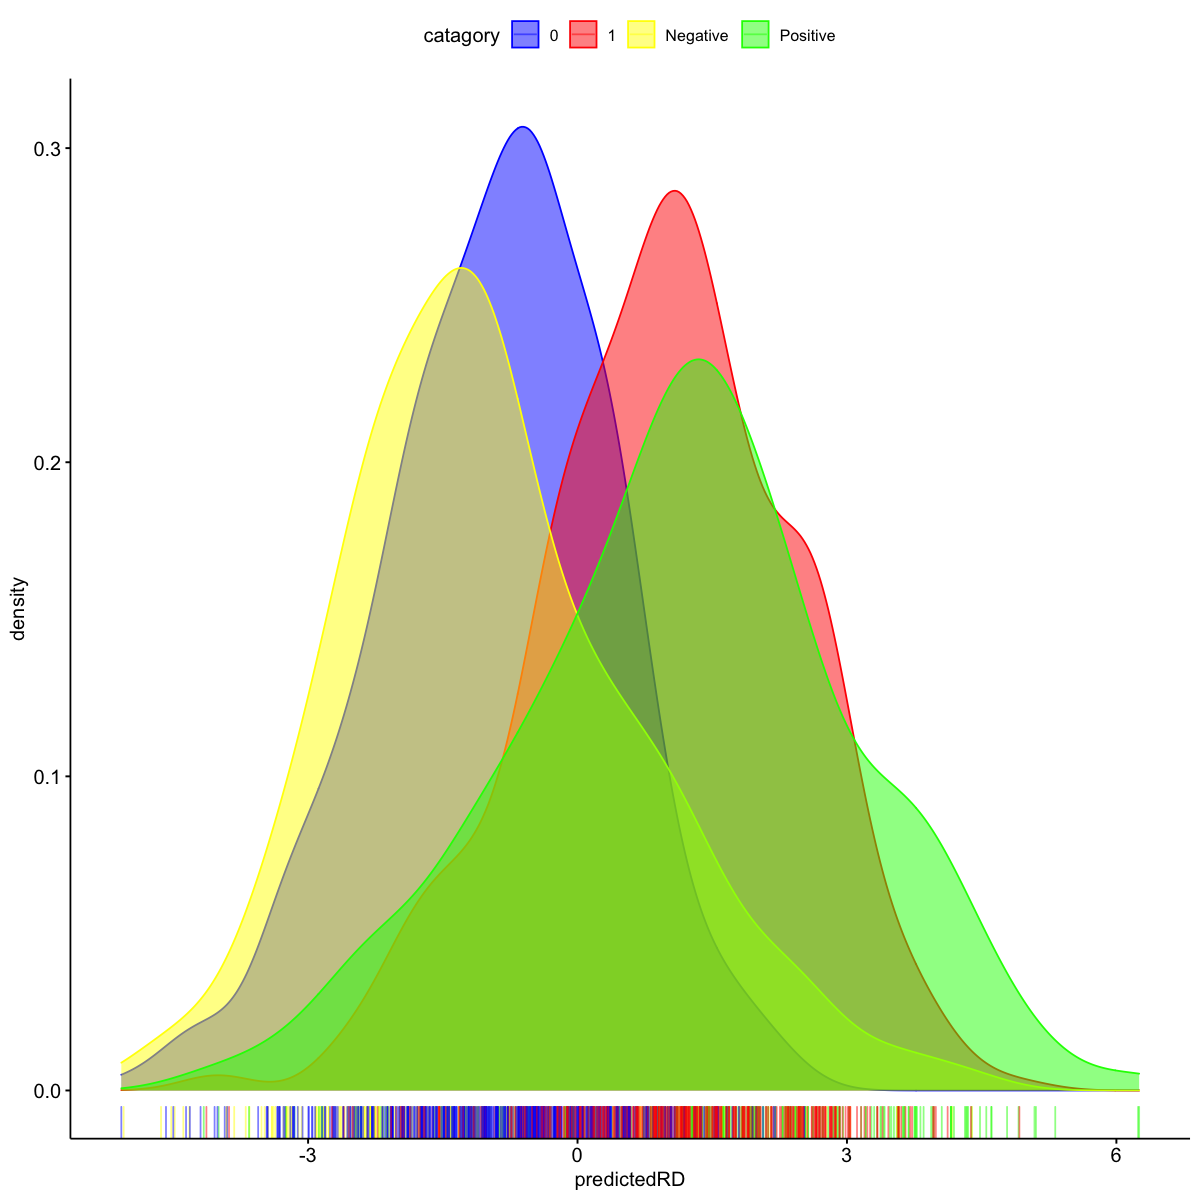

In [30]:
predicted_RD$catagory <- ifelse(predicted_RD$Y==0,"Negative","Positive")
colnames(plot.data) <- c("catagory","predictedRD")

final_RD_table <- rbind(
    predicted_RD[c("predictedRD","catagory")],
    plot.data[c("predictedRD","catagory")]
)
    
ggdensity(final_RD_table, x = "predictedRD",
          rug = TRUE,
          color = "catagory", fill = "catagory",
          palette = c("blue", "red","yellow","green"))

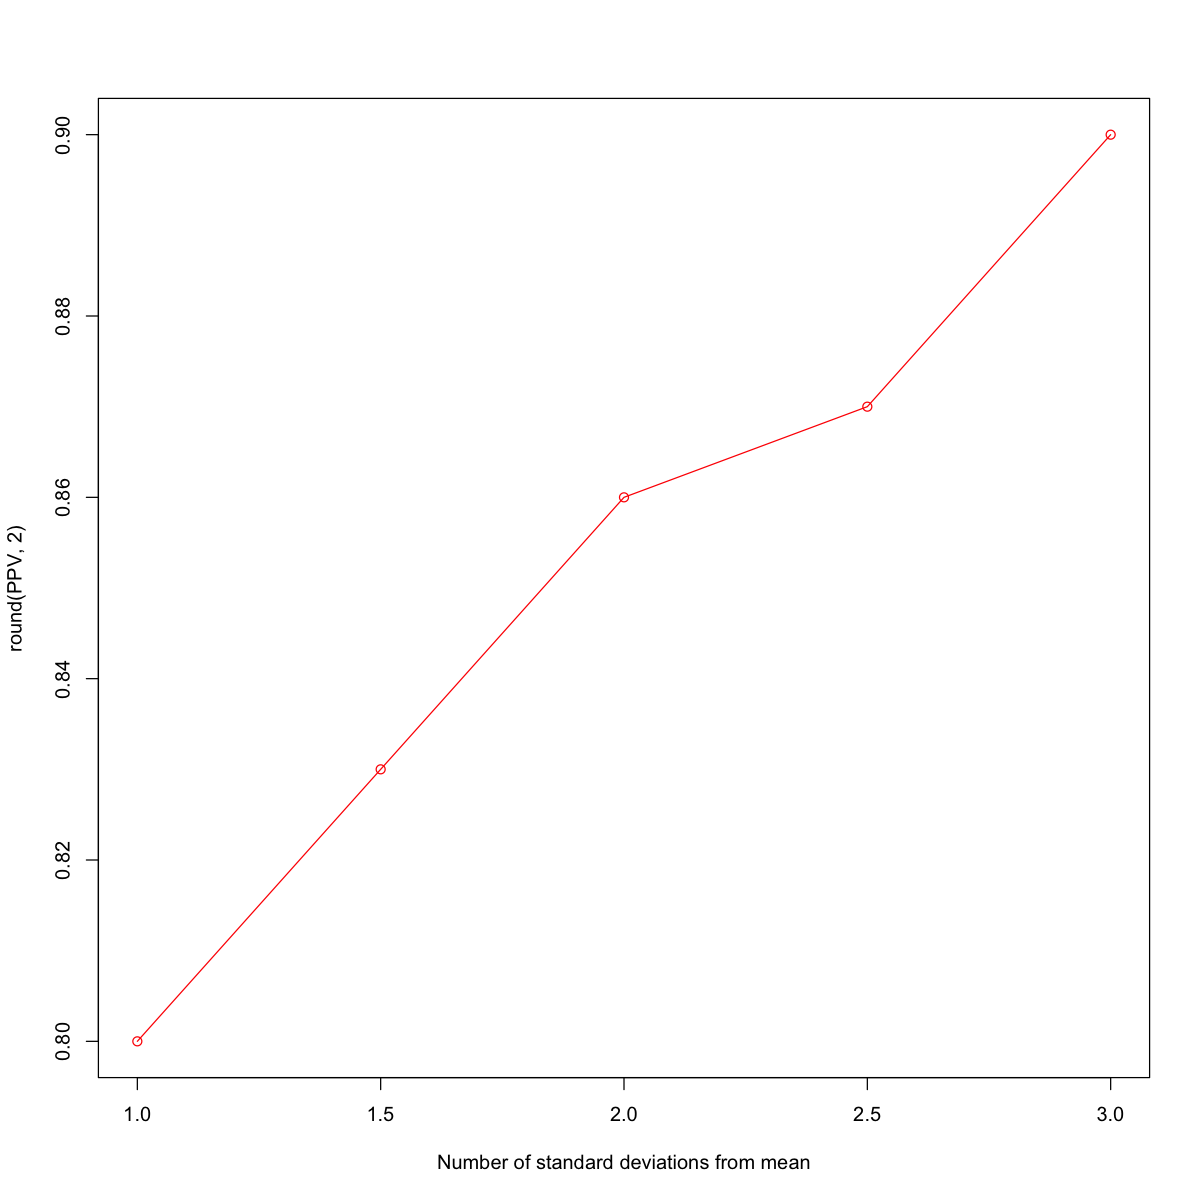

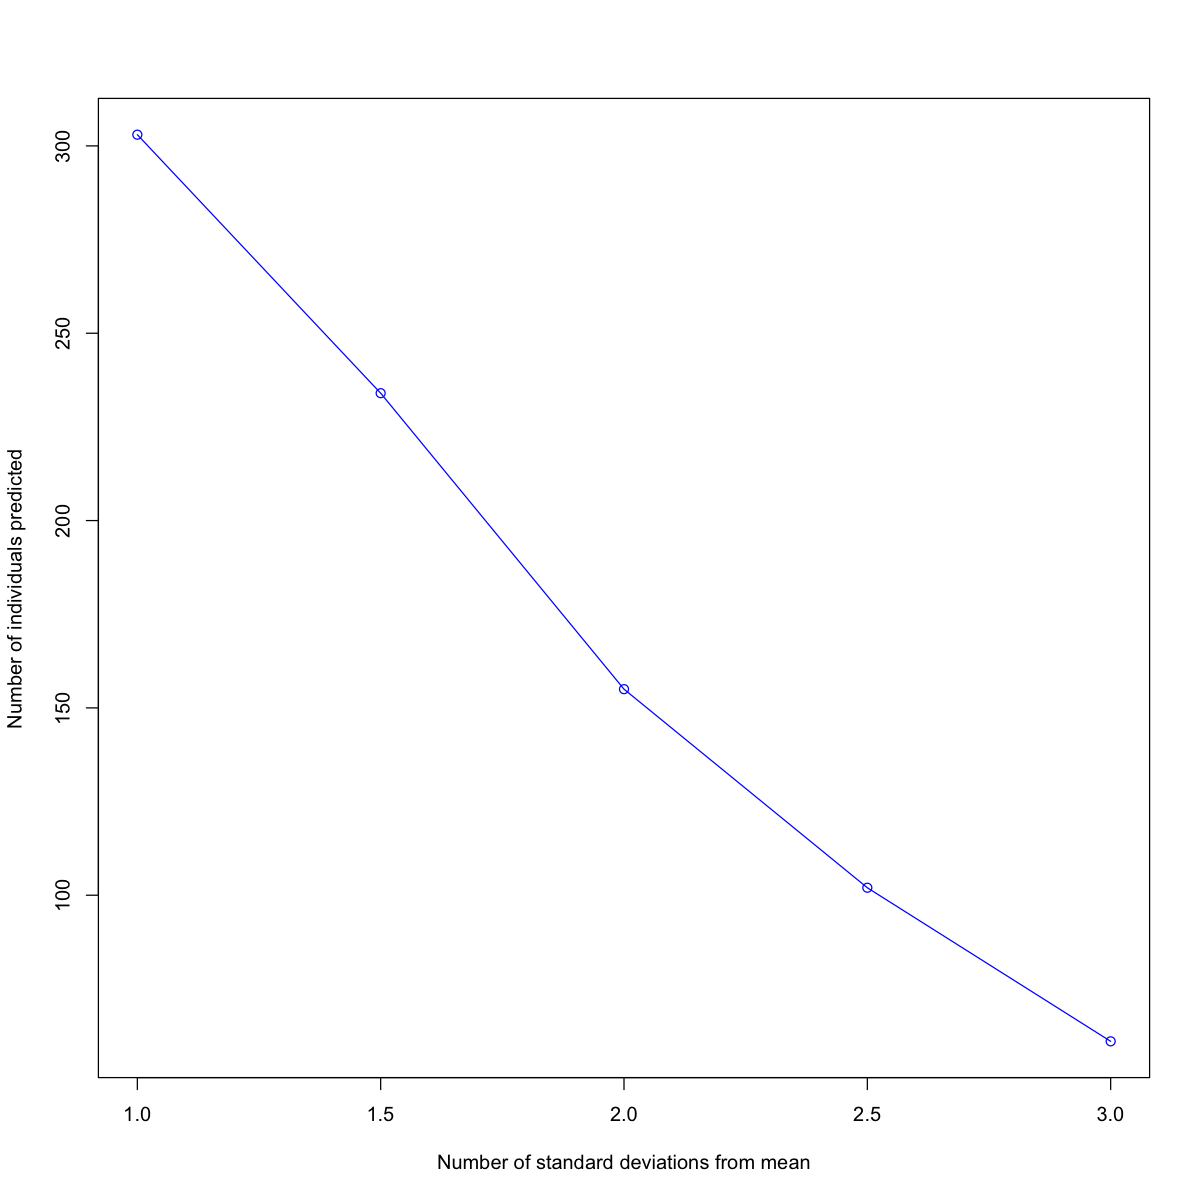

In [31]:
#################################################
PPV <-c()
num_of_predicted_ind <- c()
#stdev <- sd(plot.data[plot.data$catagory==0,]$risk_distance)#increase n
#mean_PRD <- mean(plot.data[plot.data$catagory==0,]$risk_distance)
n_controls <- c()
n_cases <- c()


for(n in seq(1,3,0.5)){
    cutoff <- n*stdev_controls
    cutoff <- mean_controls + cutoff
    
    predicted_RD_cutoff <- predicted_RD[predicted_RD$predictedRD>cutoff,]
    #n_controls_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==0,])[1]
    #n_cases_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1,])[1]
    predicted_RD_cutoff$predicted_Y <- as.numeric(ifelse(predicted_RD_cutoff$predictedRD>cutoff,1,0))
    
    PPV <- c(PPV,
             dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1 & predicted_RD_cutoff$predicted_Y==1 ,])[1]/dim(predicted_RD_cutoff[predicted_RD_cutoff$predicted_Y==1 ,])[1])
    num_of_predicted_ind <- c(num_of_predicted_ind,dim(predicted_RD_cutoff)[1])
}

plot(x=seq(1,3,0.5),y=round(PPV,2),type="o",col="red",xlab="Number of standard deviations from mean")
plot(x=seq(1,3,0.5),y=num_of_predicted_ind,type="o",col="blue",xlab="Number of standard deviations from mean",ylab="Number of individuals predicted")

In [32]:
num_of_predicted_ind
PPV

[1] 303 234 155 102  61

[1] 0.7986799 0.8333333 0.8580645 0.8725490 0.9016393

In [33]:
varComp1 <- selectVar(splsda_output_beta,comp = 1)
varComp2 <- selectVar(splsda_output_beta,comp = 2)

selected_C1 <- data.frame(varComp1$value)
selected_C2 <- data.frame(varComp2$value)

selected_C1$probe_id <- row.names(selected_C1)
selected_C2$probe_id <- row.names(selected_C2)

In [34]:
varible_importance <- rbind(selected_C1[order(abs(selected_C1$value.var),decreasing=T),]
,selected_C2[order(abs(selected_C2$value.var),decreasing=T),])

varible_importance$value.var <- abs(varible_importance$value.var)
varible_importance <- varible_importance[order(varible_importance$value.var,decreasing = T),]

In [35]:
selected_var <- as.character(varible_importance$probe_id)

In [36]:
selected_var <- c('status',unique(selected_var))

In [37]:
test <- data.frame(merge(sample_id_phase1,phase1_t,by.x = "id",by.y = "sample.id"))
train <- data.frame(merge(sample_id_phase2,phase2_t,by.x = "id",by.y = "sample.id"))
train <- merge(train,Aberdeen_covariates,by.x = "id",by.y="Basename")
test <- merge(test,UCL_covariates,by.x = "id",by.y = "Basename")

In [38]:
train <- train[selected_var]
test <- test[selected_var]


Attaching package: ‘caret’


The following objects are masked from ‘package:mixOmics’:

    nearZeroVar, plsda, splsda


Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: caTools


Attaching package: ‘caTools’


The following objects are masked from ‘package:pracma’:

    combs, trapz




        predicted
observed   1   2
       1 234  88
       2 101 252

[[1]]
[1] 0.7757113

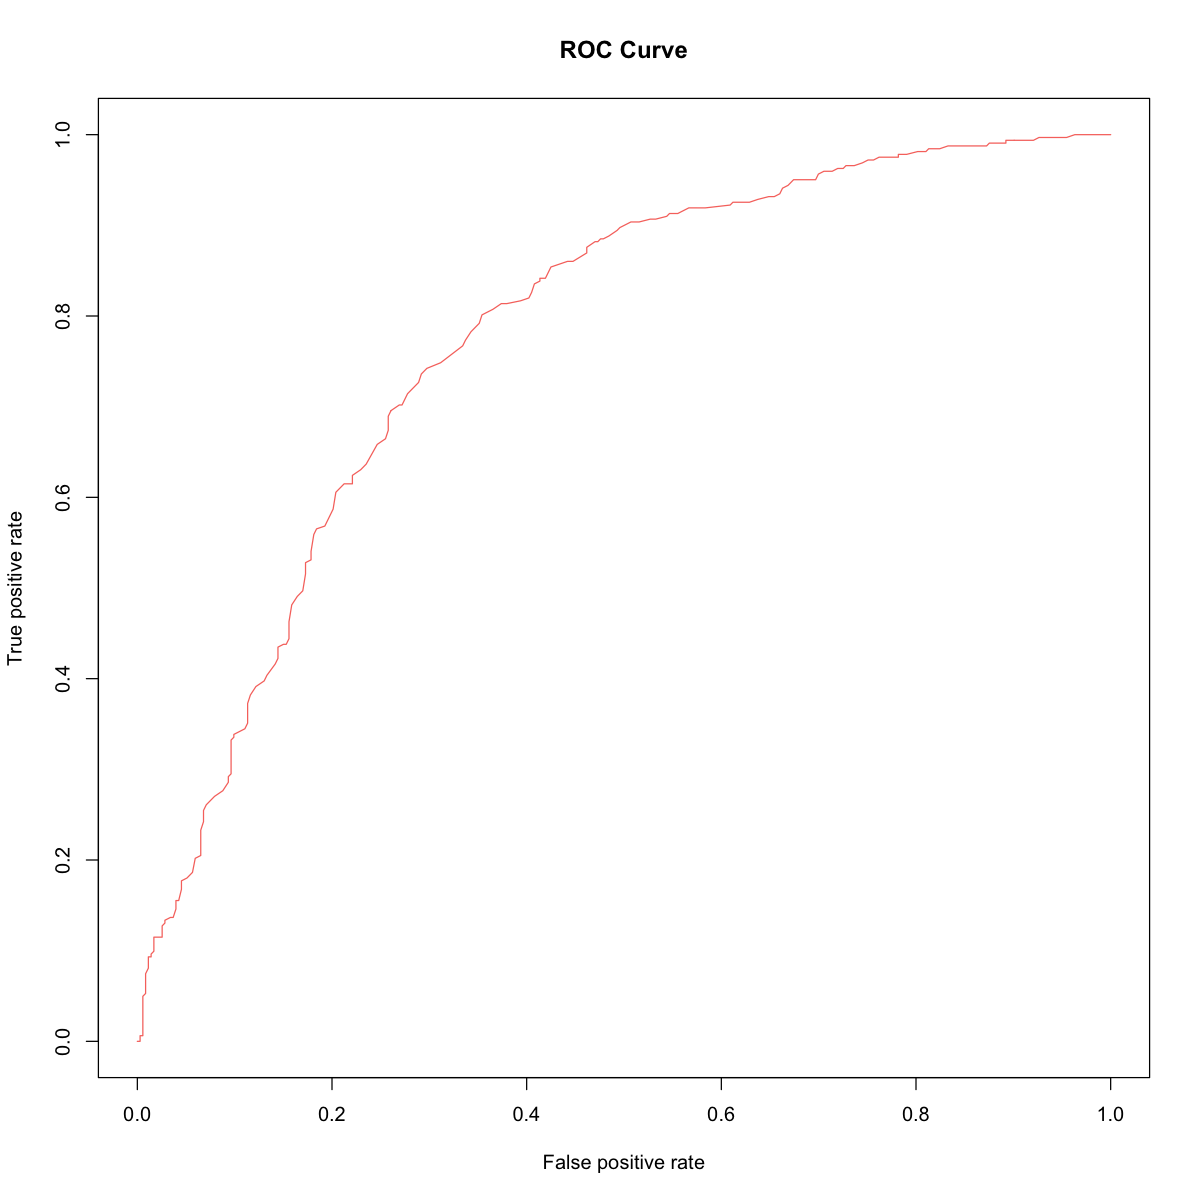

In [39]:
rf_model=randomForest(as.factor(status) ~.,data = train,ntree=500,mtry=50,importance=TRUE)
prediction <- predict(rf_model,subset(test,select = -c(status)))
table(observed = test$status,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(status)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$status))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$status==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
auc.perf@y.values

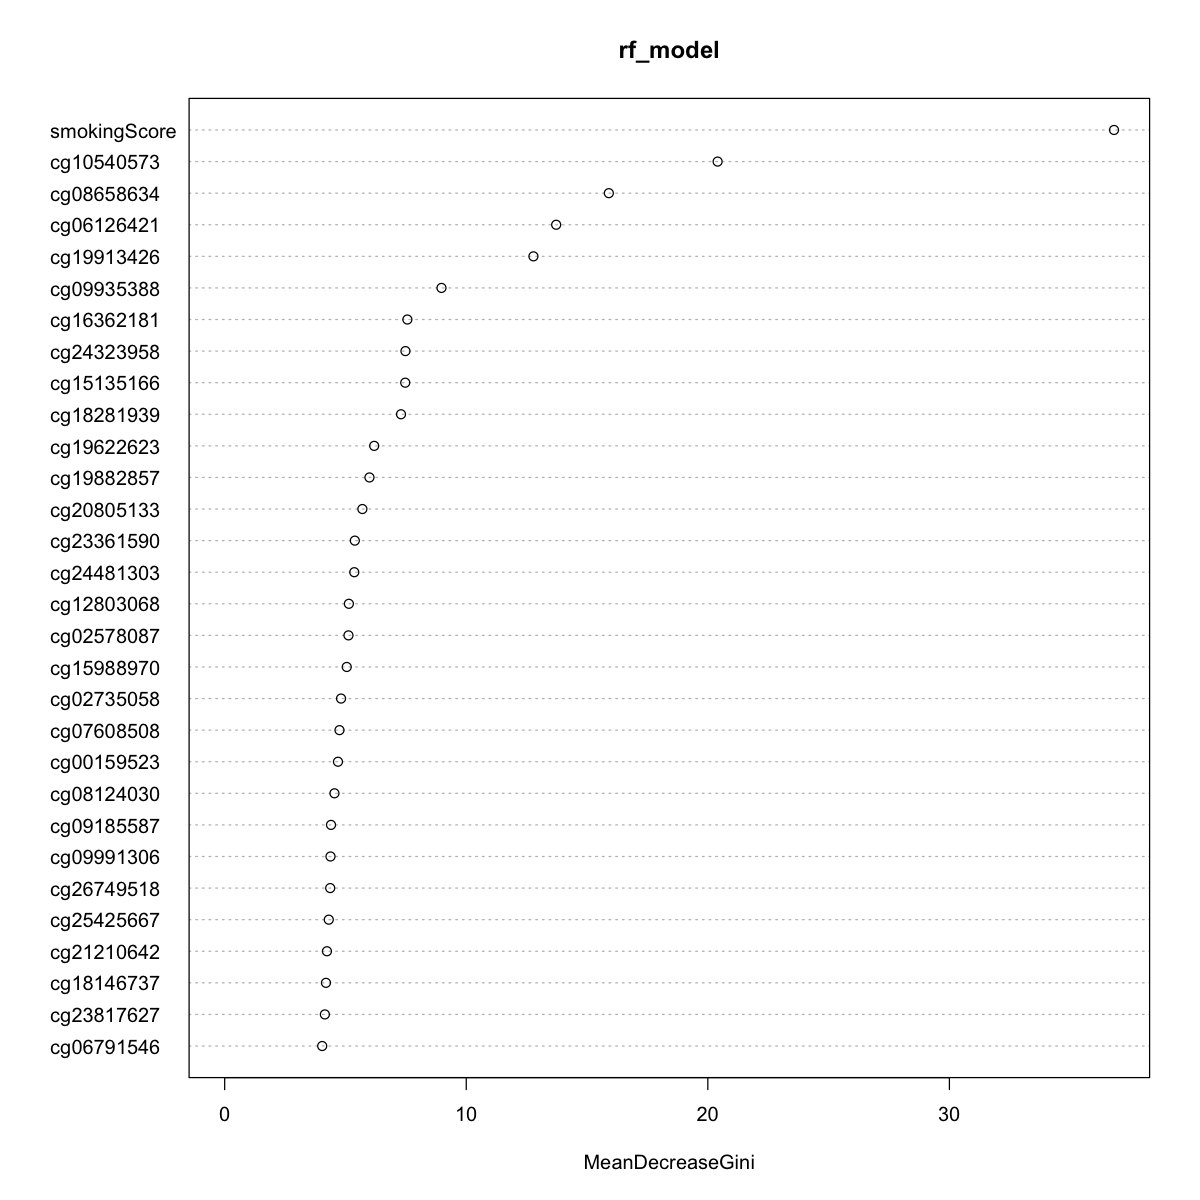

In [40]:
varImpPlot(rf_model,type = 2)

In [41]:
head(blood_brain_pearson)

Blood.vs.CER Blood.vs.STG Blood.vs.PFC Blood.vs.EC  probe_id  
1 -0.073186444  0.262599025  0.1279926    0.099451024 cg00000029
2  0.055851930 -0.041051331  0.2303407   -0.056085975 cg00000108
3  0.122785504  0.004476664 -0.2487932    0.056156542 cg00000109
4 -0.007058393  0.008950982  0.1080755    0.090457671 cg00000165
5 -0.193015498  0.058928032  0.0198772   -0.003483462 cg00000236
6 -0.031787066  0.018381015 -0.1480315    0.133296479 cg00000289

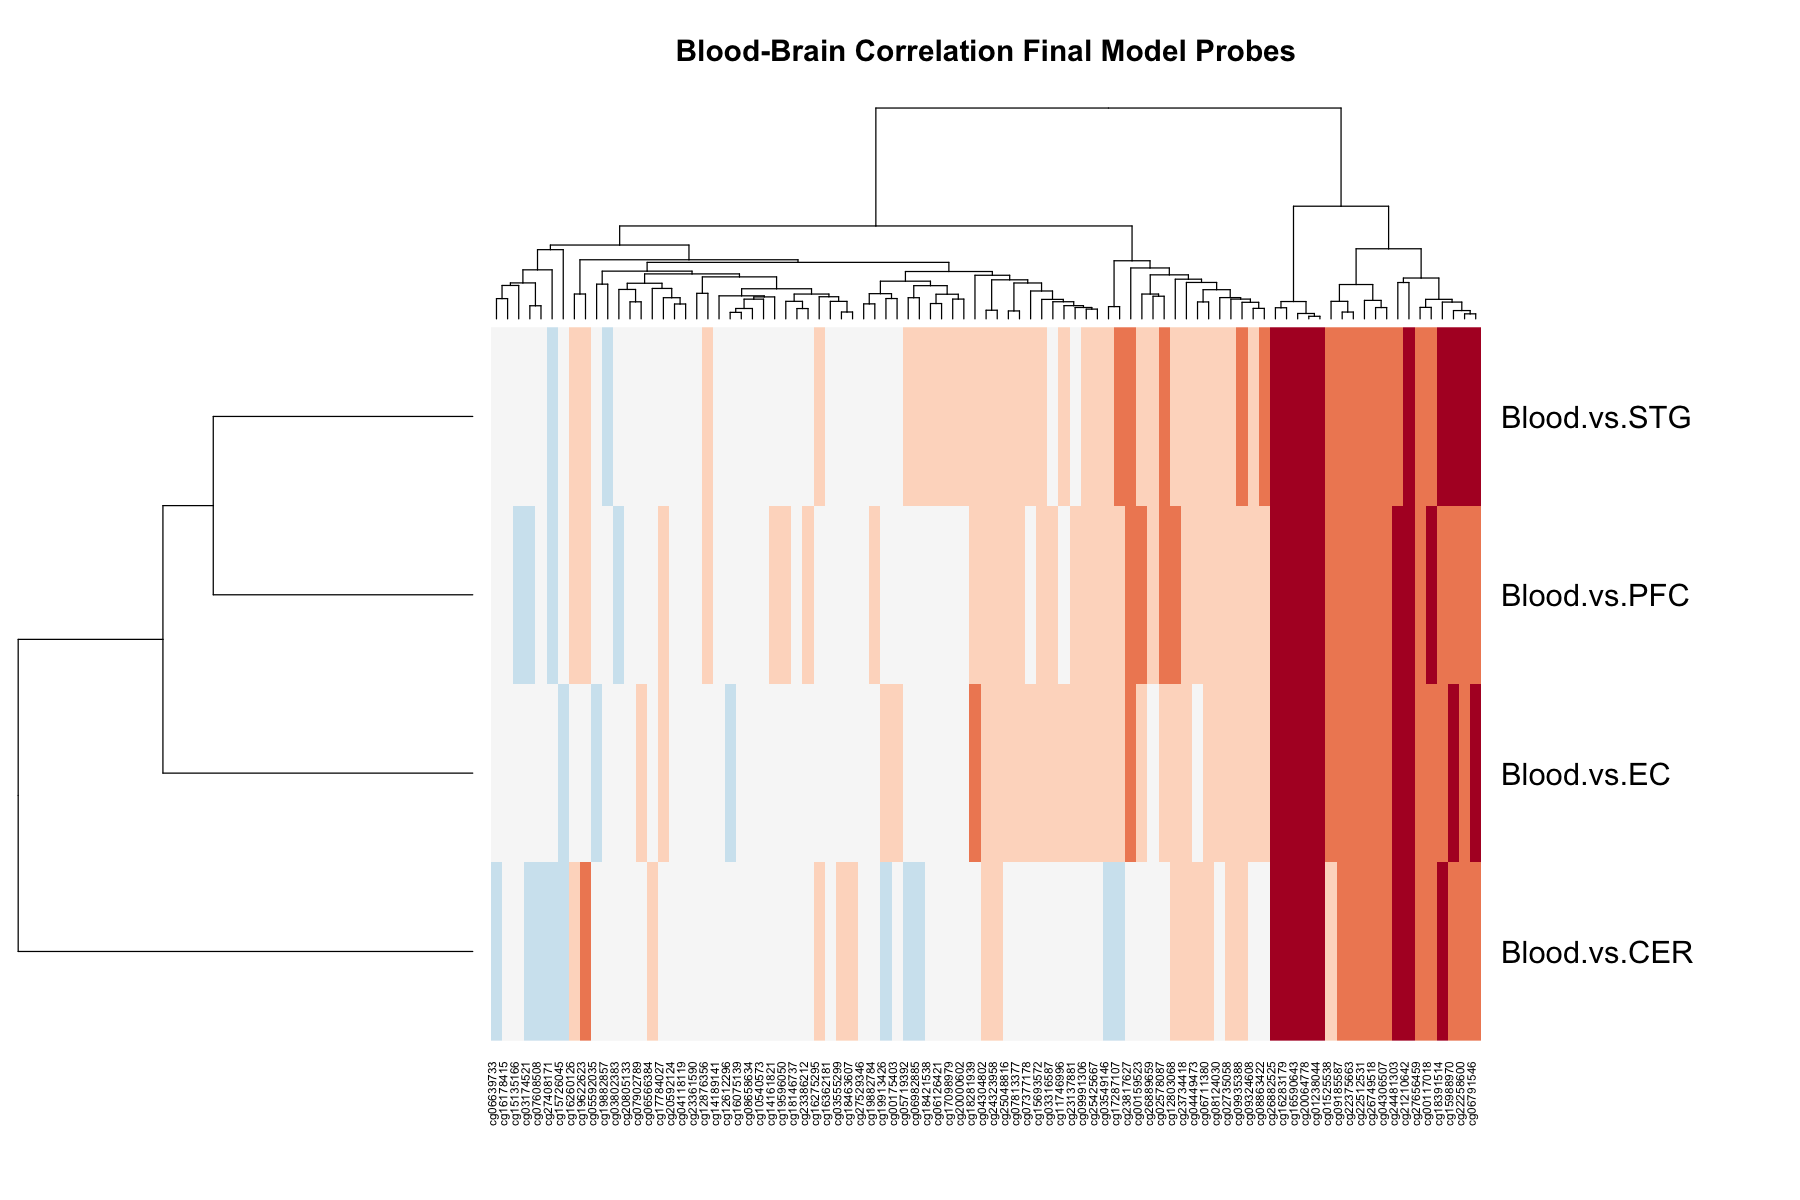

In [42]:
data <- subset(blood_brain_pearson, probe_id %in% selected_var)
rownames(data) <- data$probe_id
data$probe_id <- NULL
options(repr.plot.width=15, repr.plot.height=10)
heatmap.2(as.matrix(t(data)),col=rev(brewer.pal(7,"RdBu")),main = "Blood-Brain Correlation Final Model Probes",
          trace="none",margins = c(8, 16),
          distfun = function(x) dist(x, method="manhattan"),
          hclustfun = function(x) hclust(x,method="average"),scale="none",key = FALSE)

In [43]:
predicted_RD$Basename <- UCL_covariates$Basename

In [44]:
UCL_PRS <- read.csv("./UCL_PRS.csv")


In [45]:
predicted_RD <- merge(predicted_RD,UCL_PRS,by="Basename")

In [46]:
cor.test(predicted_RD$predictedRD,predicted_RD$SCORE,method = "spearman")


	Spearman's rank correlation rho

data:  predicted_RD$predictedRD and predicted_RD$SCORE
S = 31967102, p-value = 1.219e-11
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2648889 



********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend




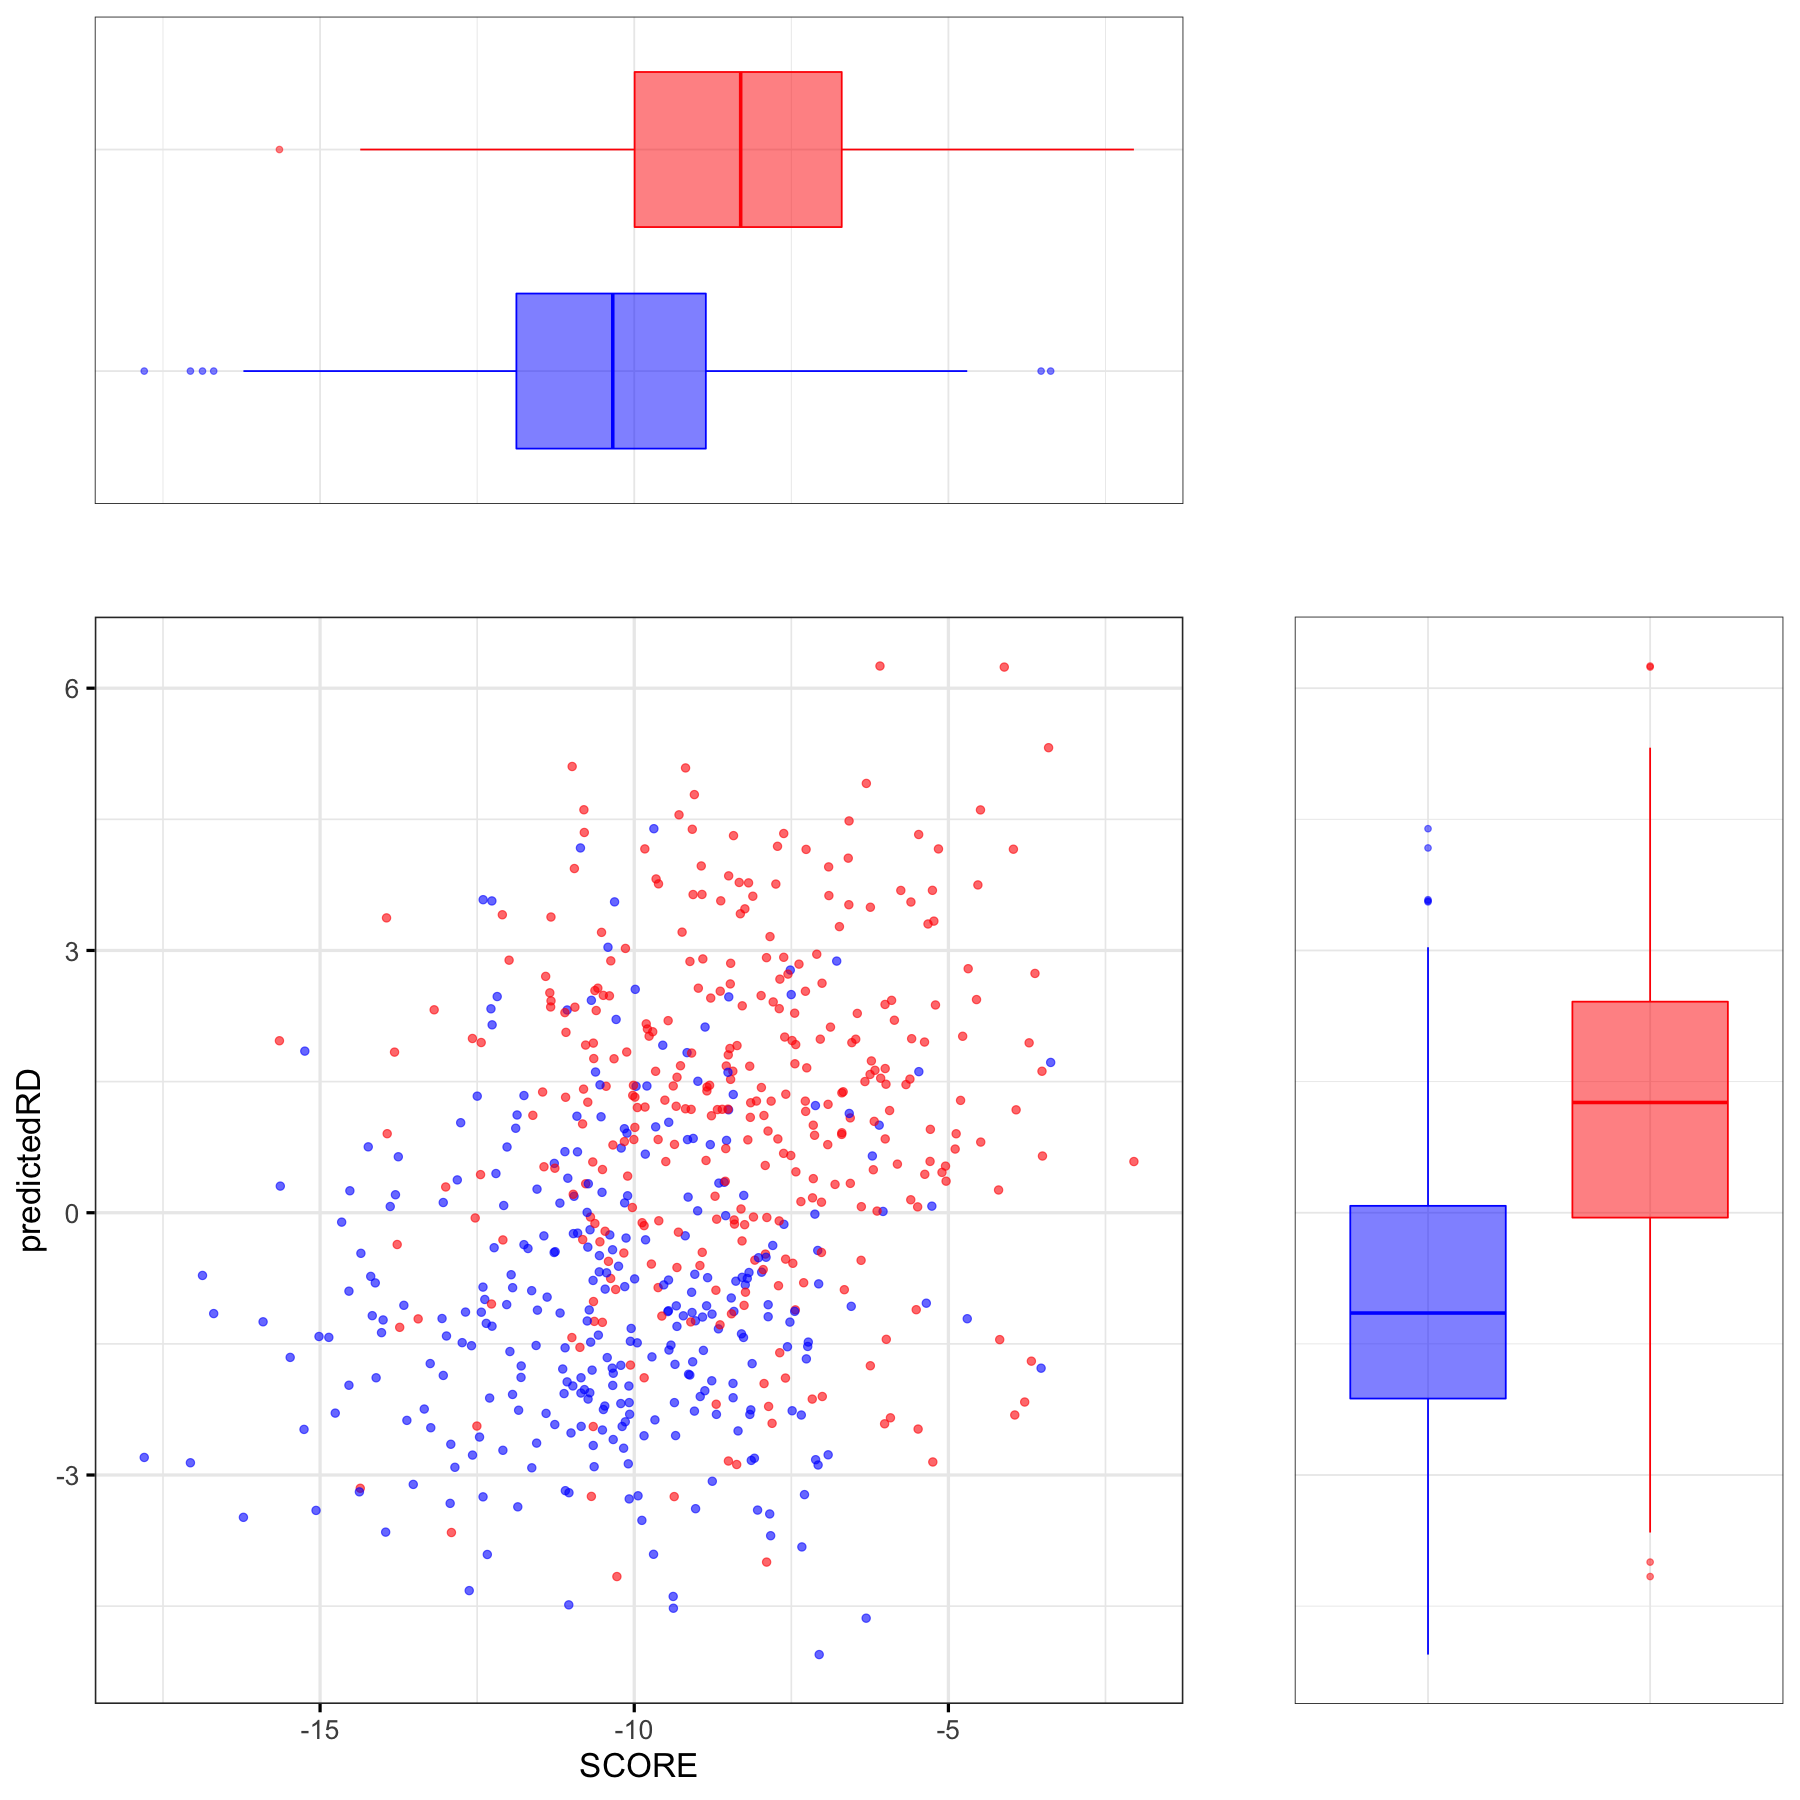

In [47]:
options(repr.plot.width=15, repr.plot.height=15)
sp <- ggscatter(predicted_RD, x = "SCORE", y = "predictedRD",
                color = "catagory", palette = c("blue","red"),
                size = 2, alpha = 0.6, ggtheme = theme_bw(base_size = 20))             
# Marginal boxplot of x (top panel) and y (right panel)
xplot <- ggboxplot(predicted_RD, x = "catagory", y = "SCORE", 
                   color = "catagory", fill = "catagory", palette = c("blue","red"),
                   alpha = 0.5, ggtheme = theme_bw())+
  rotate()
yplot <- ggboxplot(predicted_RD, x = "catagory", y = "predictedRD",
                   color = "catagory", fill = "catagory", palette = c("blue","red"),
                   alpha = 0.5, ggtheme = theme_bw())
# Cleaning the plots
sp <- sp + rremove("legend")
yplot <- yplot + clean_theme() + rremove("legend")
xplot <- xplot + clean_theme() + rremove("legend")
# Arranging the plot using cowplot

plot_grid(xplot, NULL, sp, yplot, ncol = 2, align = "hv", 
          rel_widths = c(2, 1), rel_heights = c(1, 2))


In [48]:
head(predicted_RD)

Basename          predictedRD Y catagory SCORE     
1 9704031032_R02C01 -1.3998250  0 Negative -10.570962
2 9704031032_R06C01 -2.8327947  0 Negative  -8.137330
3 9721367113_R04C02  2.0633410  1 Positive -11.086439
4 9721367113_R05C01  0.7285703  1 Positive  -4.892436
5 9721367113_R06C01 -1.1307634  0 Negative  -9.464871
6 9721367113_R06C02 -2.3913907  0 Negative -10.142752

In [49]:


fit.totaleffect=glm(Y~SCORE,predicted_RD,family = "binomial")
summary(fit.totaleffect)

fit.mediator=lm(predictedRD~SCORE,data=predicted_RD)
summary(fit.mediator)

fit.dv=glm(Y~SCORE+predictedRD,data=predicted_RD,family = "binomial")
summary(fit.dv)

summary(mediate(fit.mediator, fit.dv, treat='SCORE', mediator='predictedRD',robustSE = TRUE, sims = 1000))


Call:
glm(formula = Y ~ SCORE, family = "binomial", data = predicted_RD)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2390  -1.0336   0.4797   0.9938   2.2224  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.74088    0.39640   9.437   <2e-16 ***
SCORE        0.39125    0.04129   9.477   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 884.86  on 638  degrees of freedom
Residual deviance: 766.83  on 637  degrees of freedom
AIC: 770.83

Number of Fisher Scoring iterations: 3



Call:
lm(formula = predictedRD ~ SCORE, data = predicted_RD)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7148 -1.4509 -0.1167  1.3497  5.3738 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.2565     0.3021   7.468 2.68e-13 ***
SCORE         0.2261     0.0312   7.247 1.24e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.013 on 637 degrees of freedom
Multiple R-squared:  0.07617,	Adjusted R-squared:  0.07472 
F-statistic: 52.52 on 1 and 637 DF,  p-value: 1.238e-12



Call:
glm(formula = Y ~ SCORE + predictedRD, family = "binomial", data = predicted_RD)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5515  -0.7891   0.2381   0.7686   2.7090  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.38510    0.44786   7.558 4.08e-14 ***
SCORE        0.35725    0.04664   7.659 1.87e-14 ***
predictedRD  0.60230    0.05842  10.309  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 884.86  on 638  degrees of freedom
Residual deviance: 622.68  on 636  degrees of freedom
AIC: 628.68

Number of Fisher Scoring iterations: 5



Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

                         Estimate 95% CI Lower 95% CI Upper p-value    
ACME (control)           0.002232     0.000877         0.00  <2e-16 ***
ACME (treated)           0.001655     0.000565         0.00  <2e-16 ***
ADE (control)            0.005154     0.002351         0.01  <2e-16 ***
ADE (treated)            0.004577     0.002066         0.01  <2e-16 ***
Total Effect             0.006809     0.002947         0.01  <2e-16 ***
Prop. Mediated (control) 0.322921     0.242172         0.42  <2e-16 ***
Prop. Mediated (treated) 0.233802     0.163661         0.33  <2e-16 ***
ACME (average)           0.001943     0.000721         0.00  <2e-16 ***
ADE (average)            0.004866     0.002195         0.01  <2e-16 ***
Prop. Mediated (average) 0.278362     0.204146         0.37  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 639 


Simulations: 1000 
